# Connection and Credentials

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import sys
sys.path.insert(0, 'drive/Graduation Project/Colaboratory')

# Libraries and Testing GPU

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16323164577410915399, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11288962663
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11202263796168302749
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Data Reading, Cleansing, Preprocessing

In [0]:
df = pd.read_csv('drive/Graduation Project/Colaboratory/user_data_anonymized.csv')
df = df.drop([df.columns[0]],axis=1)

In [8]:
df.head()

user_id username     acc_x     acc_y     acc_z    gyro_x    gyro_y  \
0        0   User_1  0.032867 -0.011398 -0.989441  0.001340 -0.004726   
1        0   User_1  0.036270 -0.646866 -0.749863  0.001340 -0.004726   
2        0   User_1  0.036270 -0.646866 -0.749863  0.001340 -0.004726   
3        0   User_1 -0.061005 -0.691040 -0.748917  0.320133  0.039149   
4        0   User_1 -0.140427 -0.746765 -0.741333  0.381414  0.046364   

     gyro_z  type  ntrial                timestamp  
0  0.000653     0       3  2018-03-15 21:49:02.853  
1  0.000653     0       3  2018-03-15 21:49:02.876  
2  0.000653     0       3  2018-03-15 21:49:02.903  
3 -0.234852     0       3  2018-03-15 21:49:03.052  
4 -0.343133     0       3  2018-03-15 21:49:03.074

In [0]:
cols = ['sensor_type','trial','name','type','set']
SEQ_LENGTH = 303
OVERLAP = 0
for i in range(SEQ_LENGTH):
    cols.append('x'+str(i))
moving_window_x = pd.DataFrame(columns = cols)

label = pd.DataFrame(columns = ['sensor_type','set','type1','type2','type3','type4'])
s_index = 0
for trial in np.sort(df['ntrial'].unique()):
    nt = df.loc[df['ntrial'] == trial]

    names = df['username'].unique()
    for name in names:
        n = nt.loc[nt['username'] == name]
        
        types = np.array([1,2,3,4])
        for type_ in types:
            t = n.loc[n['type'] == type_]
            
            sensors = t.columns[2:8]
            for sensor in sensors:  
                s = t
                
                if trial == 5: text="test"
                else: text="train"
                    
                row = np.array([sensor])
                row = np.append(row,[trial])
                row = np.append(row,[name])
                row = np.append(row,[type_])
                row = np.append(row,[text])
                if s[sensor].values.shape[0] > SEQ_LENGTH:
                    row = np.append(row,s[sensor].values[:SEQ_LENGTH].astype(float))
                    #print(s[sensor].values[:SEQ_LENGTH])
                elif s[sensor].values.shape[0] <= SEQ_LENGTH:
                    padded_row = np.append(s[sensor].values[:].astype(float),np.array([s[sensor].values[-1].astype(float) for i in range(SEQ_LENGTH-s[sensor].values.shape[0])]))
                    row = np.append(row,padded_row)
                moving_window_x = moving_window_x.append(pd.DataFrame([row],columns=moving_window_x.columns))
                
                row_label = np.array([sensor])
                row_label = np.append(row_label,[text])
                row_label = np.append(row_label,np.zeros((types.shape[0],)))
                row_label[type_+1] = 1.0
                label = label.append(pd.DataFrame([row_label],columns=label.columns))
                
    s_index += s[sensor].shape[0]

In [10]:
mdf = moving_window_x
mdf.head()

sensor_type trial    name type    set           x0           x1  \
0       acc_x     1  User_1    1  train     0.197403     0.197403   
0       acc_y     1  User_1    1  train   -0.9118347   -0.9118347   
0       acc_z     1  User_1    1  train    -0.321167    -0.321167   
0      gyro_x     1  User_1    1  train   0.04131851   0.04131851   
0      gyro_y     1  User_1    1  train  -0.01665488  -0.01665488   

                    x2                    x3                    x4  \
0           0.08113098            0.09988403             0.0811615   
0  -0.9439086999999999             -0.970932            -0.9682465   
0            -0.262146             -0.226944  -0.23547359999999998   
0           0.01131534             0.1071343            0.07671592   
0           0.01434938  0.006068456999999999          -0.004963335   

          ...                            x293                 x294  \
0         ...                     -0.01829529          0.002685547   
0         ...                      -0.7836456            -0.764328   
0         ...                      -0.6551056           -0.6021271   
0         ...            -0.25480610000000004  0.17817460000000002   
0         ...           0.0017532479999999998           0.01696966   

                  x295                 x296                 x297  \
0          0.002685547          0.002685547          0.002685547   
0            -0.764328            -0.764328            -0.764328   
0           -0.6021271           -0.6021271           -0.6021271   
0  0.17817460000000002  0.17817460000000002  0.17817460000000002   
0           0.01696966           0.01696966           0.01696966   

                  x298                 x299                 x300  \
0          0.002685547          0.002685547          0.002685547   
0            -0.764328            -0.764328            -0.764328   
0           -0.6021271           -0.6021271           -0.6021271   
0  0.17817460000000002  0.17817460000000002  0.17817460000000002   
0           0.01696966           0.01696966           0.01696966   

                  x301                 x302  
0          0.002685547          0.002685547  
0            -0.764328            -0.764328  
0           -0.6021271           -0.6021271  
0  0.17817460000000002  0.17817460000000002  
0           0.01696966           0.01696966  

[5 rows x 308 columns]

In [0]:
moving_window_x['index'] = [i for i in range(moving_window_x.shape[0])]
moving_window_x = moving_window_x.set_index(['index'])

label['index'] = [i for i in range(label.shape[0])]
label = label.set_index(['index'])

In [12]:
moving_window_x.shape

(240, 308)

In [13]:
moving_window_x.head()

sensor_type trial    name type    set           x0           x1  \
index                                                                   
0           acc_x     1  User_1    1  train     0.197403     0.197403   
1           acc_y     1  User_1    1  train   -0.9118347   -0.9118347   
2           acc_z     1  User_1    1  train    -0.321167    -0.321167   
3          gyro_x     1  User_1    1  train   0.04131851   0.04131851   
4          gyro_y     1  User_1    1  train  -0.01665488  -0.01665488   

                        x2                    x3                    x4  \
index                                                                    
0               0.08113098            0.09988403             0.0811615   
1      -0.9439086999999999             -0.970932            -0.9682465   
2                -0.262146             -0.226944  -0.23547359999999998   
3               0.01131534             0.1071343            0.07671592   
4               0.01434938  0.006068456999999999          -0.004963335   

              ...                            x293                 x294  \
index         ...                                                        
0             ...                     -0.01829529          0.002685547   
1             ...                      -0.7836456            -0.764328   
2             ...                      -0.6551056           -0.6021271   
3             ...            -0.25480610000000004  0.17817460000000002   
4             ...           0.0017532479999999998           0.01696966   

                      x295                 x296                 x297  \
index                                                                  
0              0.002685547          0.002685547          0.002685547   
1                -0.764328            -0.764328            -0.764328   
2               -0.6021271           -0.6021271           -0.6021271   
3      0.17817460000000002  0.17817460000000002  0.17817460000000002   
4               0.01696966           0.01696966           0.01696966   

                      x298                 x299                 x300  \
index                                                                  
0              0.002685547          0.002685547          0.002685547   
1                -0.764328            -0.764328            -0.764328   
2               -0.6021271           -0.6021271           -0.6021271   
3      0.17817460000000002  0.17817460000000002  0.17817460000000002   
4               0.01696966           0.01696966           0.01696966   

                      x301                 x302  
index                                            
0              0.002685547          0.002685547  
1                -0.764328            -0.764328  
2               -0.6021271           -0.6021271  
3      0.17817460000000002  0.17817460000000002  
4               0.01696966           0.01696966  

[5 rows x 308 columns]

In [14]:
moving_window_x.groupby(['set']).size().to_frame()

0
set       
test    48
train  192

In [0]:
train_len = int(moving_window_x.loc[moving_window_x['set'] == 'train'].shape[0]/6)
test_len = int(moving_window_x.loc[moving_window_x['set'] == 'test'].shape[0]/6)

In [0]:
x_train = np.zeros((train_len,SEQ_LENGTH,6))
y_train = np.zeros((train_len,4))

x_test = np.zeros((test_len,SEQ_LENGTH,6))
y_test = np.zeros((test_len,4))

In [0]:
shuffle_data = np.zeros((train_len+test_len,SEQ_LENGTH,6+4))

In [18]:
for i,sensor in enumerate(moving_window_x['sensor_type'].unique()):
    s_train = moving_window_x.loc[moving_window_x['sensor_type'] == sensor]
    s_train = s_train.loc[s_train['set'] == "train"]
    s_test = moving_window_x.loc[moving_window_x['sensor_type'] == sensor]
    s_test = s_test.loc[s_test['set'] == "test"]

    x_train[:,:,i] = s_train.drop(['sensor_type','trial','name','type','set'],axis=1)
    x_test[:,:,i] = s_test.drop(['sensor_type','trial','name','type','set'],axis=1)
    if i == 0:
        l = label.loc[label['sensor_type'] == sensor]
        l_train = l.loc[l['set'] == "train"]
        l_test = l.loc[l['set'] == "test"]
        
        y_train[:,:] = l_train.drop(['sensor_type','set'],axis=1)
        y_test[:,:] = l_test.drop(['sensor_type','set'],axis=1)

print("x_train.shape: "+str(x_train.shape))
print("y_train.shape: "+str(y_train.shape))
print("x_test.shape: "+str(x_test.shape))
print("y_test.shape: "+str(y_test.shape))

x_train.shape: (32, 303, 6)
y_train.shape: (32, 4)
x_test.shape: (8, 303, 6)
y_test.shape: (8, 4)


# Import Keras Library

In [19]:
from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM, Conv1D, Dropout
from keras.callbacks import History
from keras.optimizers import Adam
import seaborn as sn
import time

Using TensorFlow backend.


# **Decrease hidden units of Vanilla LSTM to prevent overfitting**

experiment:1

116 secs for training


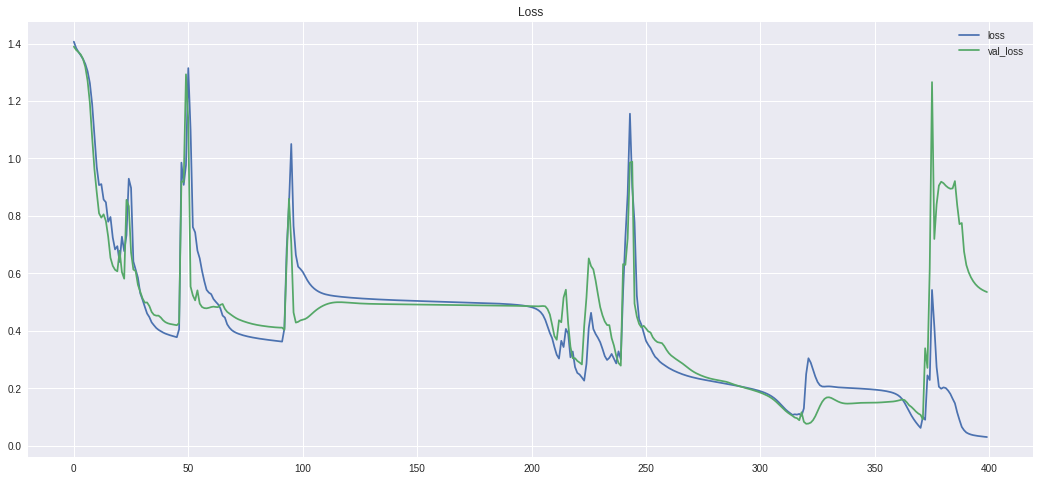

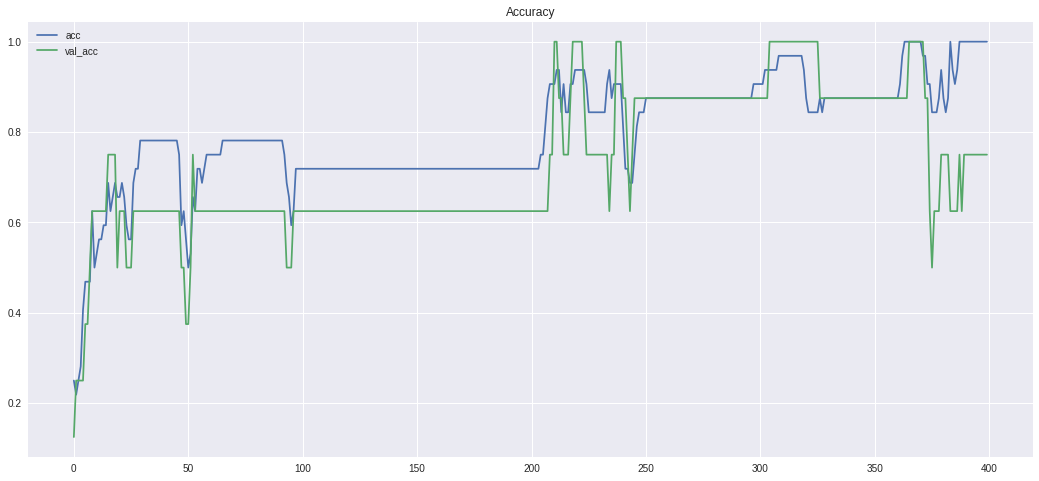

experiment:2

116 secs for training


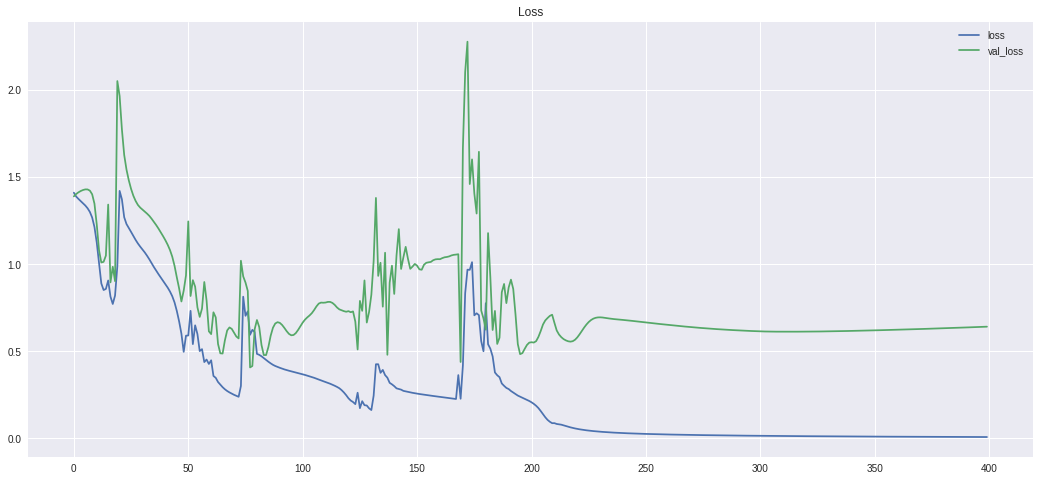

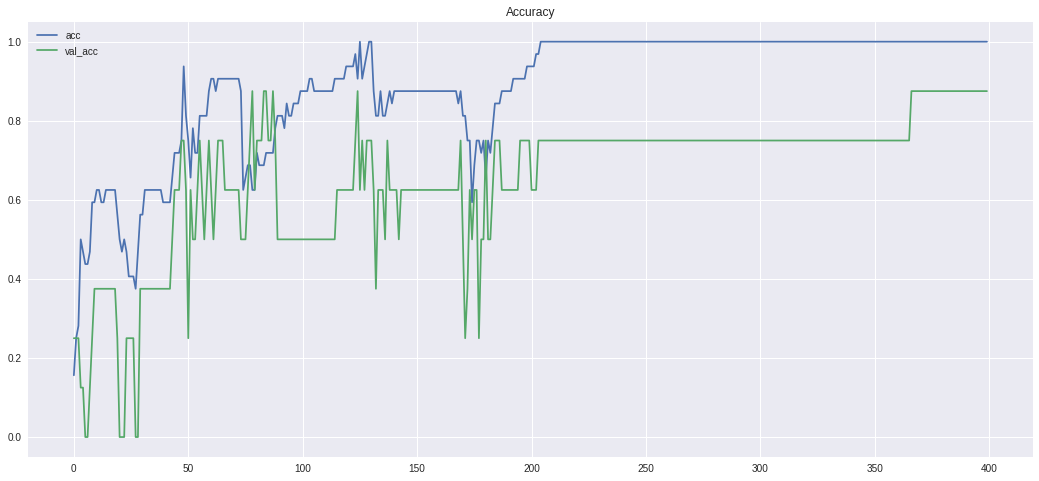

experiment:3

116 secs for training


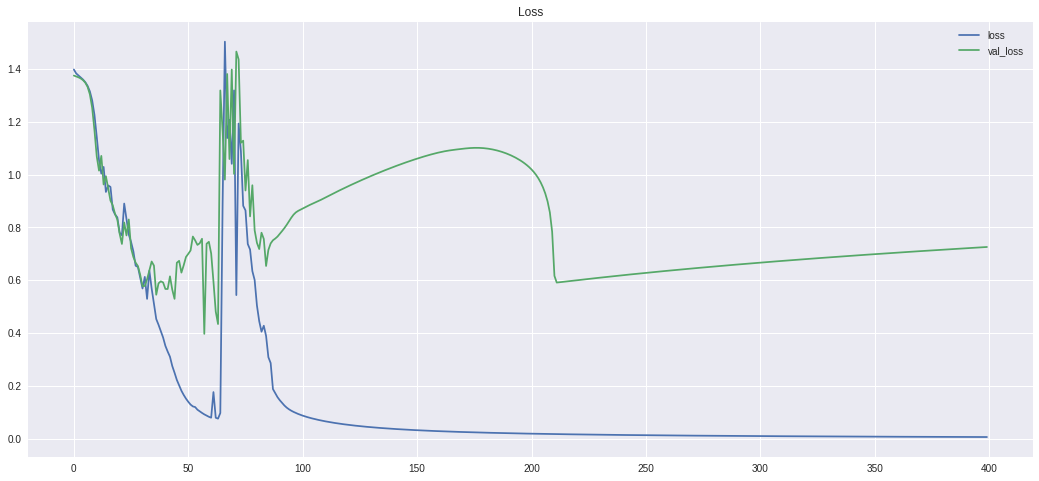

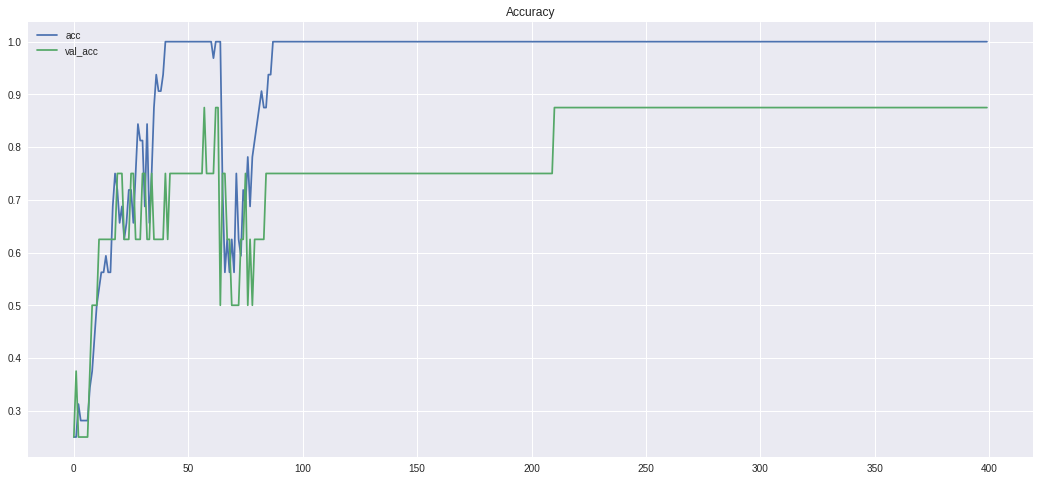

experiment:4

116 secs for training


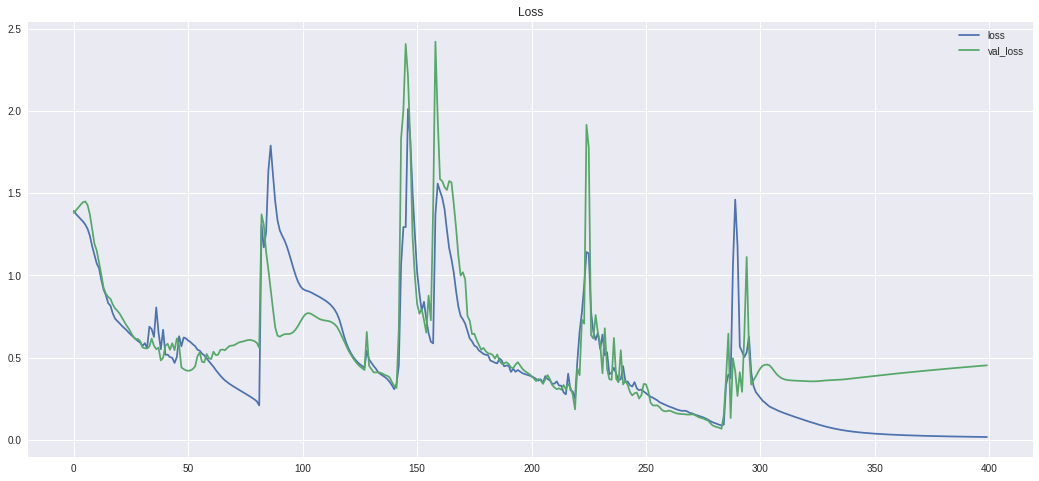

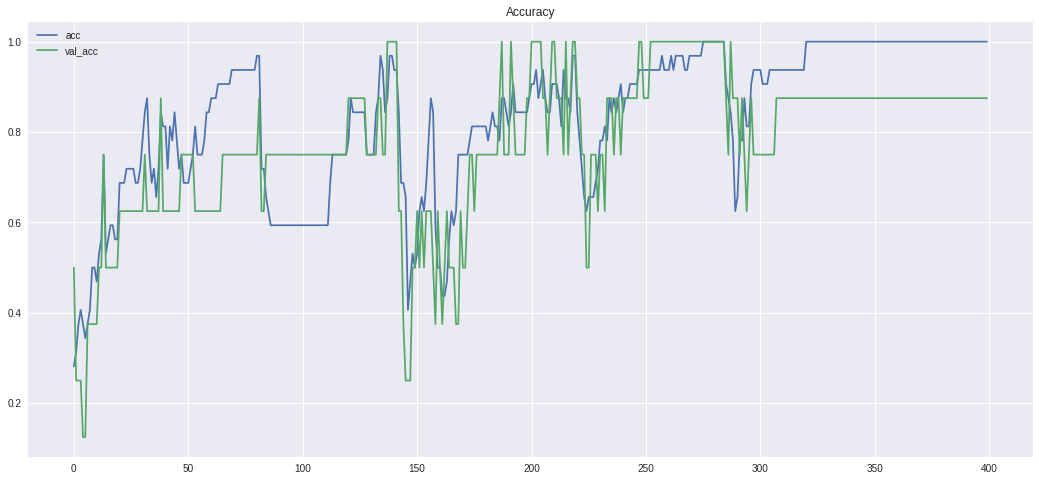

experiment:5

117 secs for training


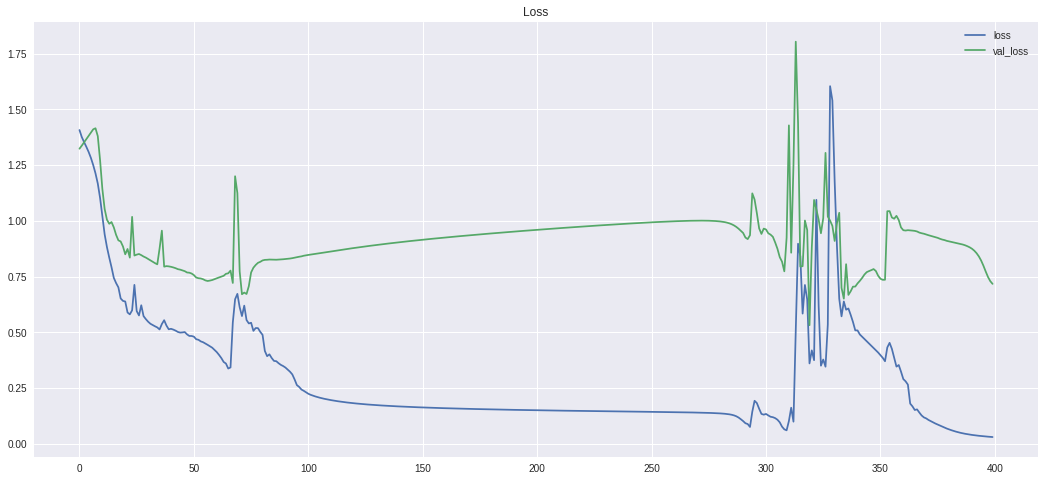

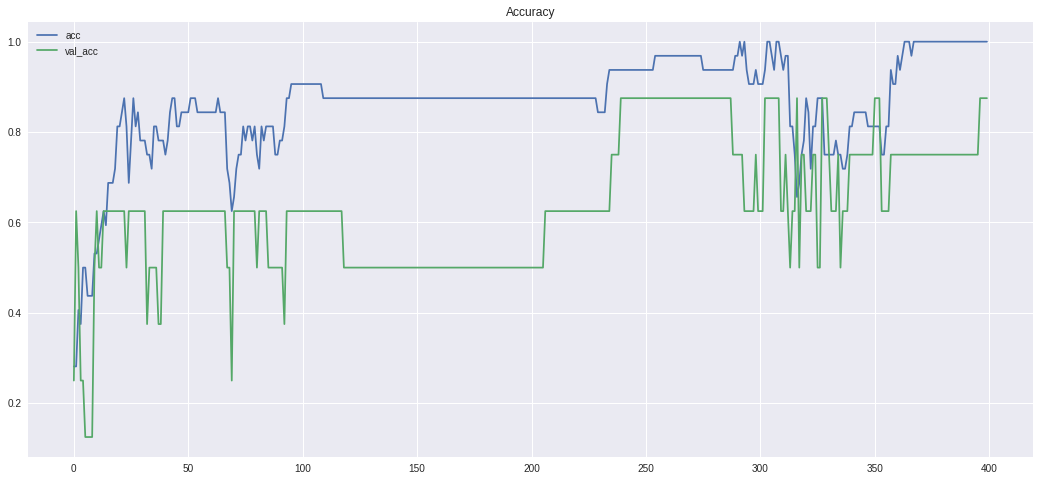

experiment:6

116 secs for training


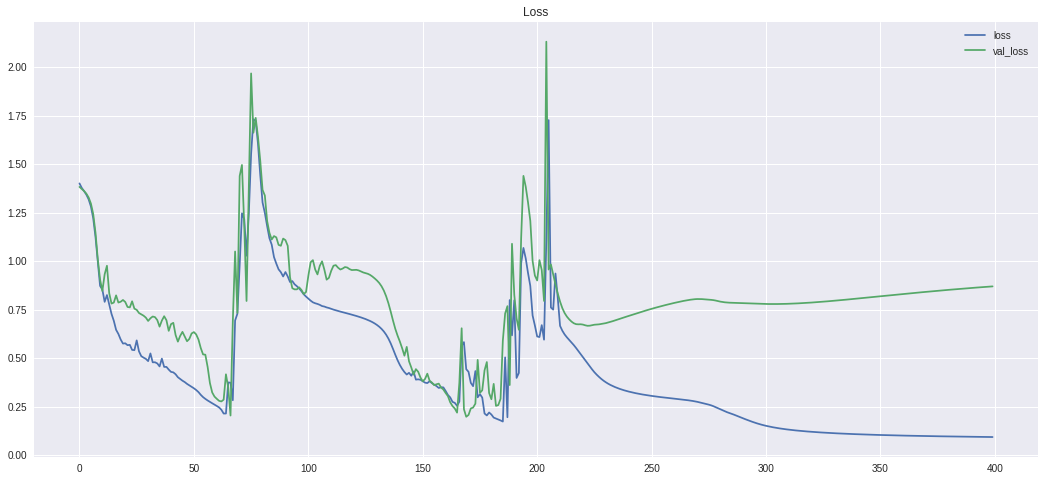

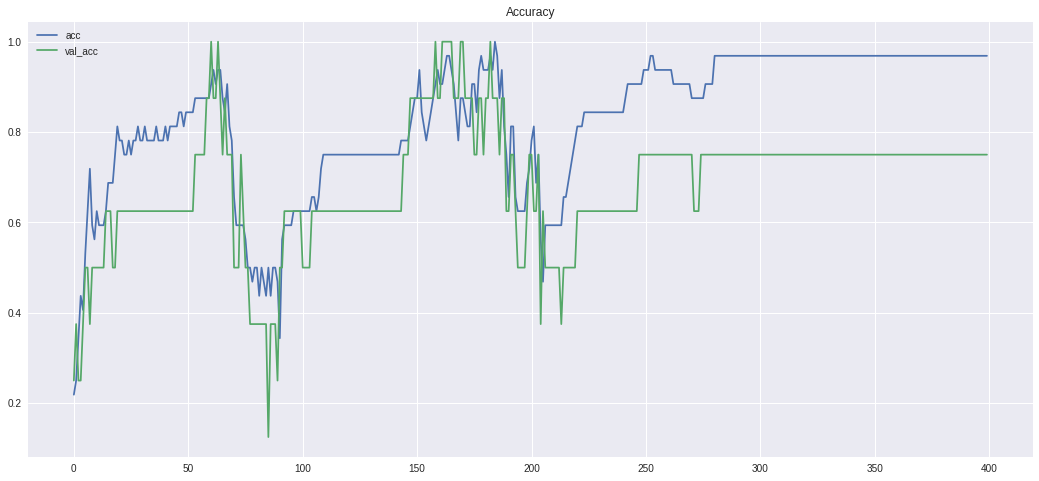

experiment:7

117 secs for training


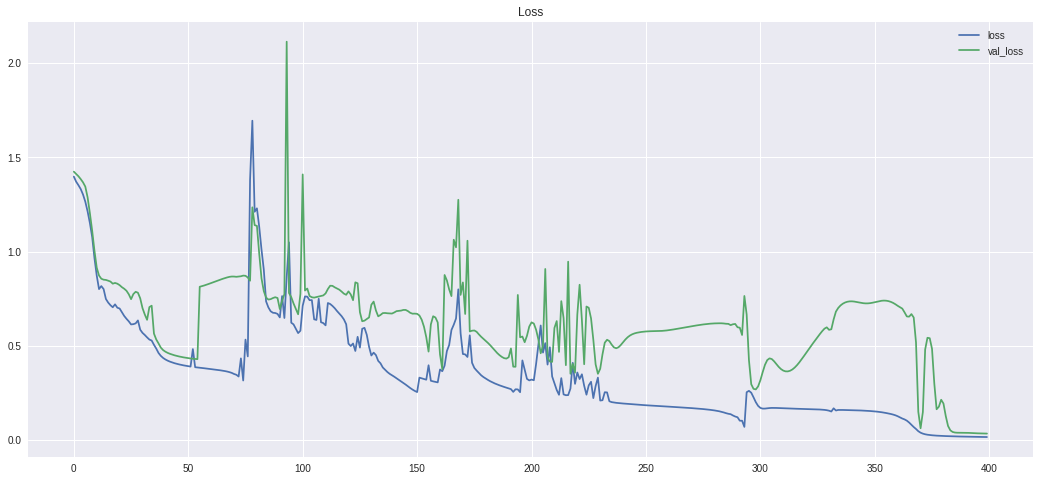

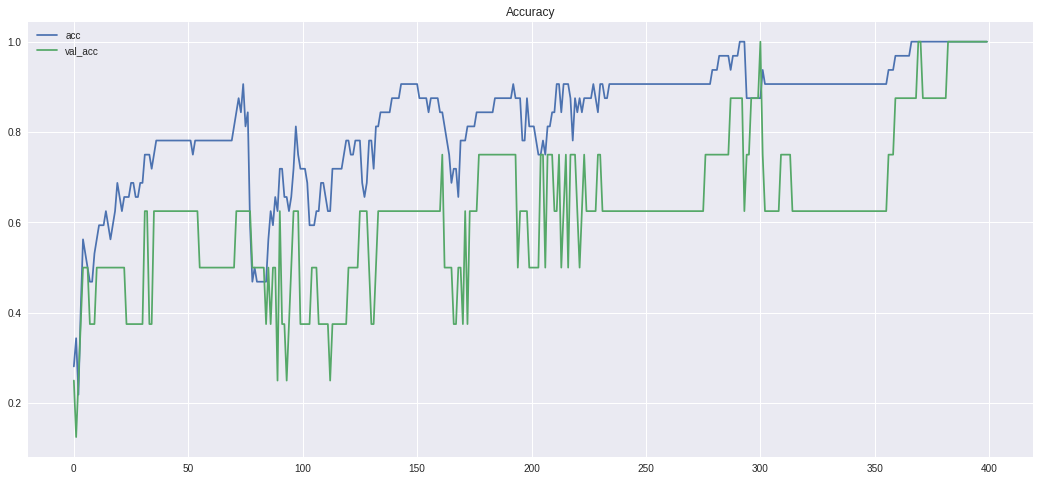

experiment:8

117 secs for training


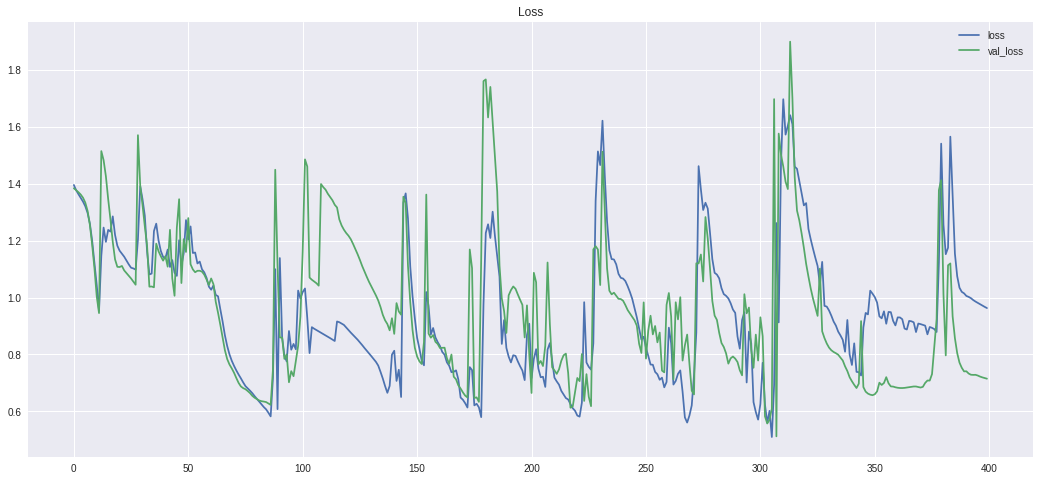

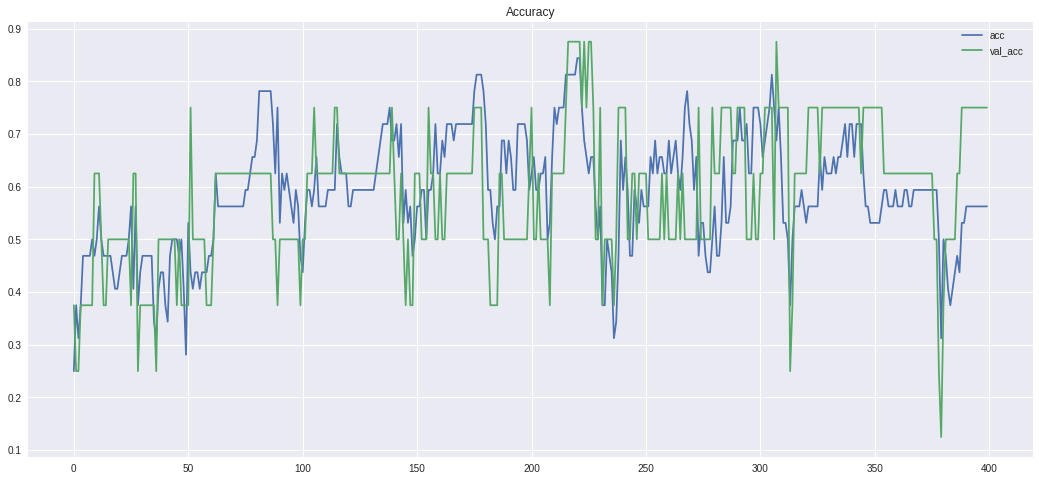

experiment:9

117 secs for training


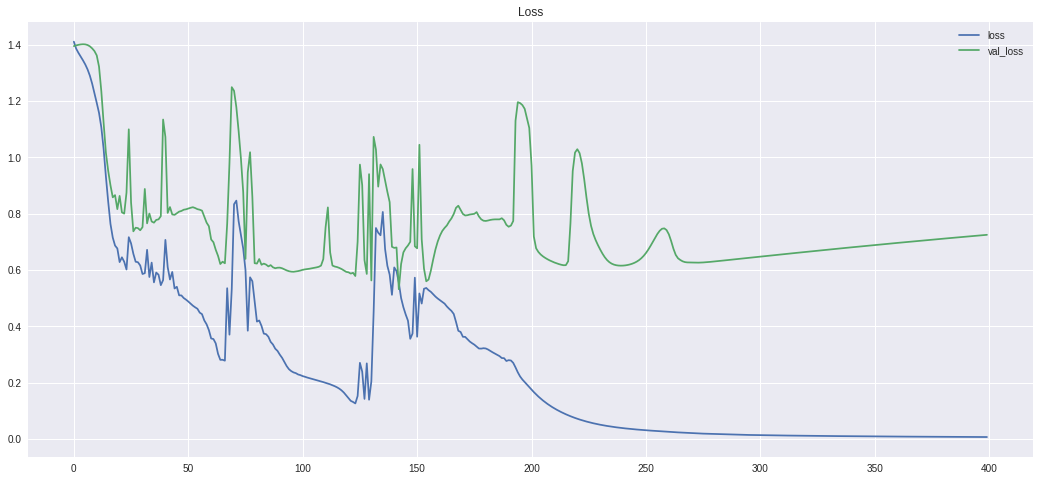

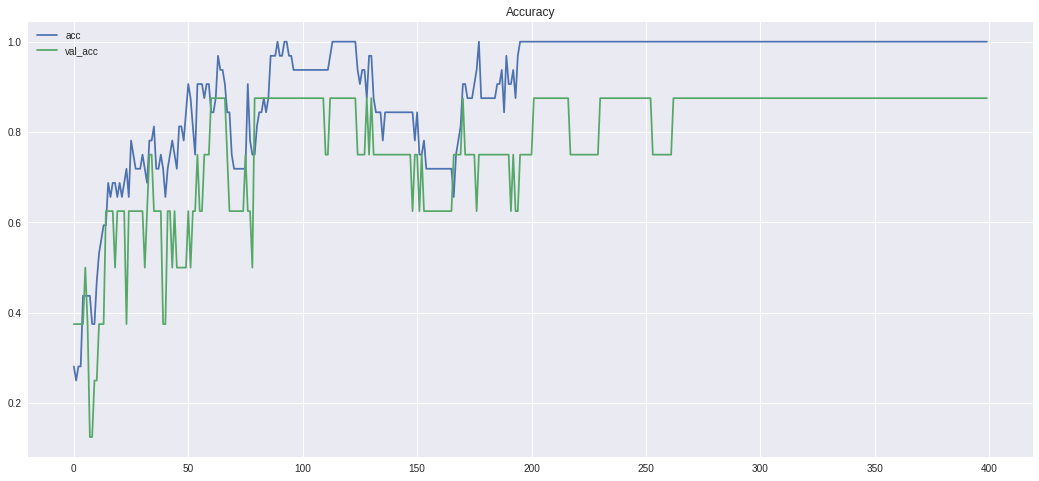

experiment:10

118 secs for training


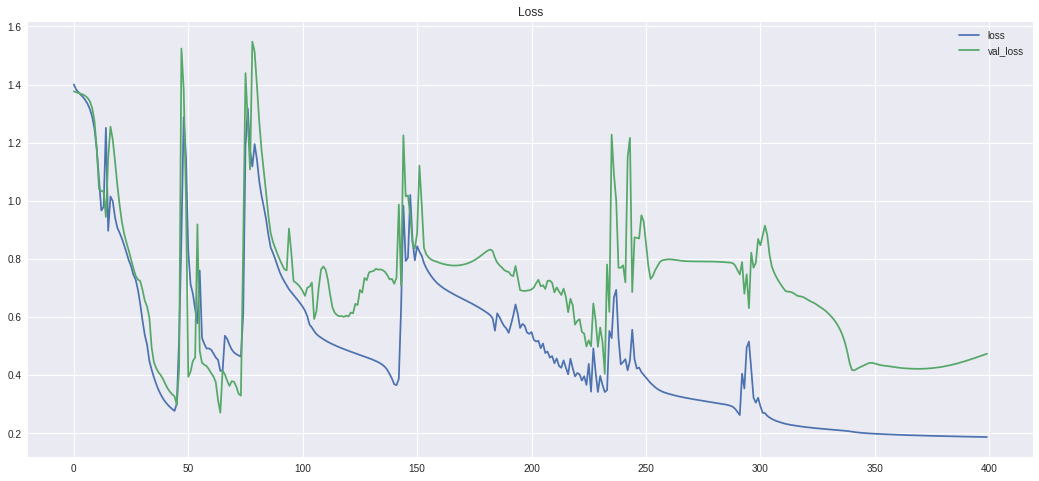

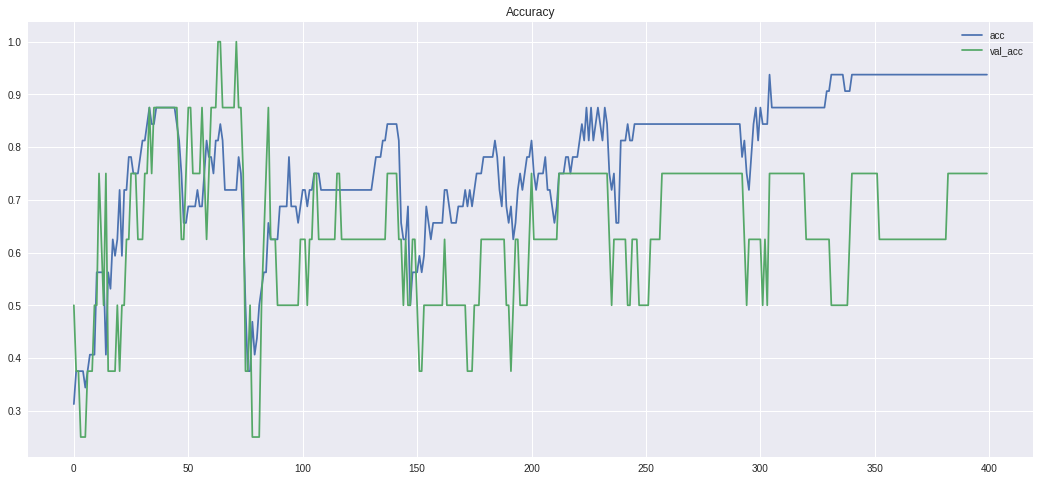

   acc_train  acc_test
0    1.00000     0.750
0    1.00000     0.875
0    1.00000     0.875
0    1.00000     0.875
0    1.00000     0.875
0    0.96875     0.750
0    1.00000     1.000
0    0.56250     0.750
0    1.00000     0.875
0    0.93750     0.750


In [30]:
acc = pd.DataFrame(columns=['acc_train','acc_test'])
for e in range(1,11):
  print("experiment:%d\n"%(e))

  y_train_ = np.zeros((32,303,4))
  y_train_[:,0,:] = y_train

  y_test_ = np.zeros((8,303,4))
  y_test_[:,0,:] = y_test

  shuffle_data[:32,:,:6] = x_train
  shuffle_data[:32,:,6:] = y_train_

  shuffle_data[32:,:,:6] = x_test
  shuffle_data[32:,:,6:] = y_test_


  while True:
    np.random.shuffle(shuffle_data)

    x_train = shuffle_data[:32,:,:6]
    x_test = shuffle_data[32:,:,:6]
    y_train = shuffle_data[:32,0,6:].reshape(32,4)
    y_test = shuffle_data[32:,0,6:].reshape(8,4)
    if np.sum(y_test[:,0]) == 2:
        if np.sum(y_test[:,1]) == 2:
            if np.sum(y_test[:,2]) == 2:
                if np.sum(y_test[:,3]) == 2:
                    break


  batch_size = 8
  timesteps = SEQ_LENGTH
  data_dim = 6


  model = Sequential()
  model.add(CuDNNLSTM(36, return_sequences=True, stateful=False,
                 batch_input_shape=(batch_size, timesteps, data_dim)))
  model.add(CuDNNLSTM(24))
  model.add(Dense(12,activation='tanh'))
  model.add(Dense(4, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])

  st = time.time()

  history = model.fit(x_train, y_train,
            batch_size=batch_size, epochs=400, shuffle=False,
            validation_data=(x_test, y_test),verbose=0)
  ft = time.time()

  print("%d secs for training"%(ft-st))

  plt.figure(figsize=(18,8))
  plt.plot(history.history['loss'],label="loss")
  plt.plot(history.history['val_loss'],label="val_loss")
  plt.title("Loss")
  plt.legend()
  plt.show()

  plt.figure(figsize=(18,8))
  plt.plot(history.history['acc'],label="acc")
  plt.plot(history.history['val_acc'],label="val_acc")
  plt.title("Accuracy")
  plt.legend()
  plt.show()

  acc = acc.append(pd.DataFrame([np.array([history.history['acc'][-1],history.history['val_acc'][-1]])],columns=acc.columns))
print(acc)

# Decreasing learning rate of Vanilla LSTM to prevent overfitting

experiment:1

137 secs for training


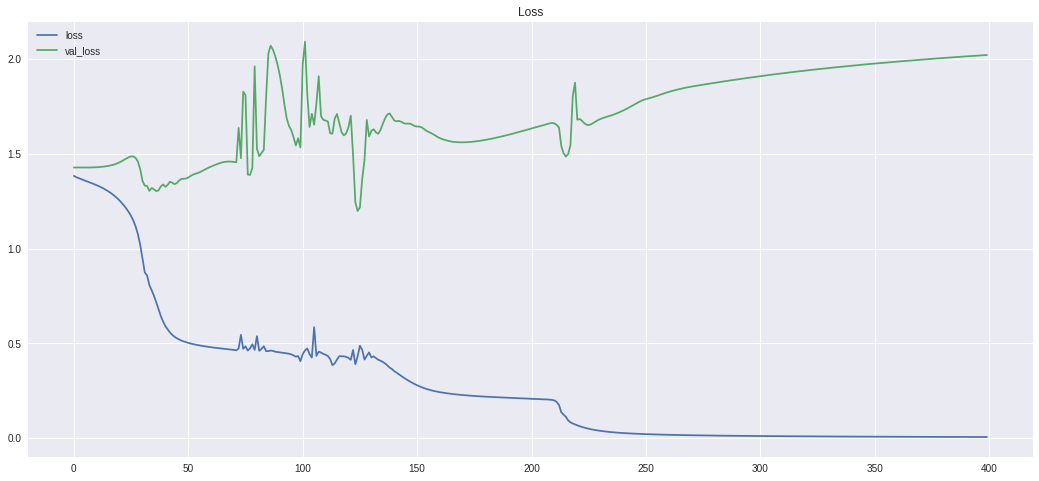

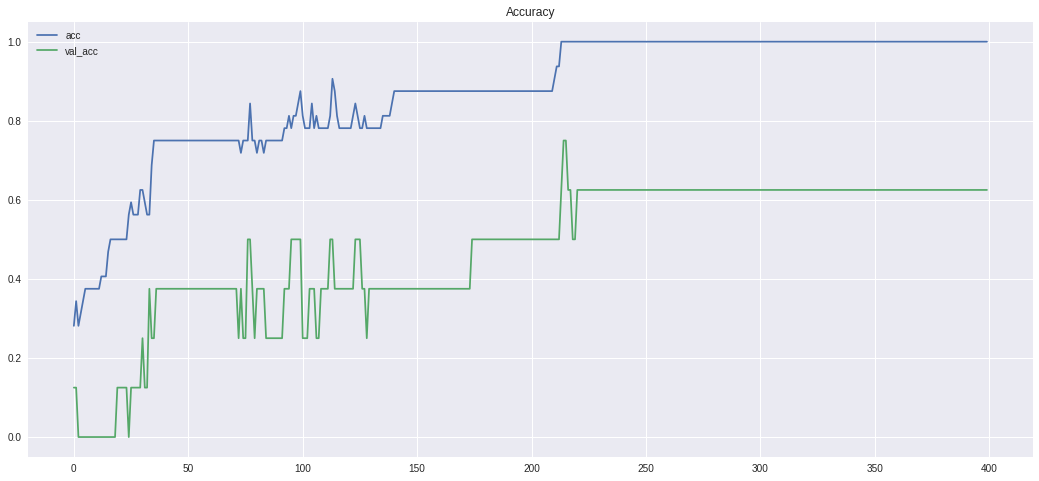

experiment:2

138 secs for training


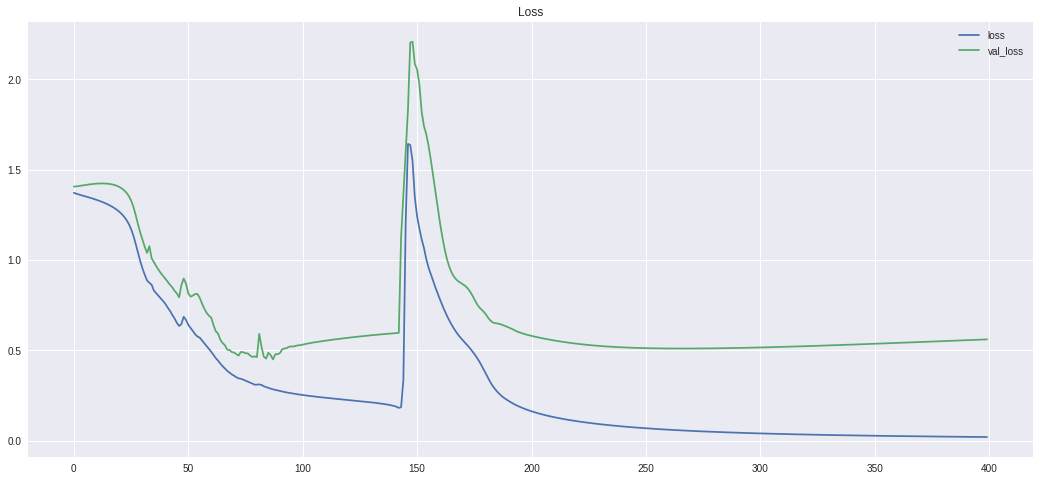

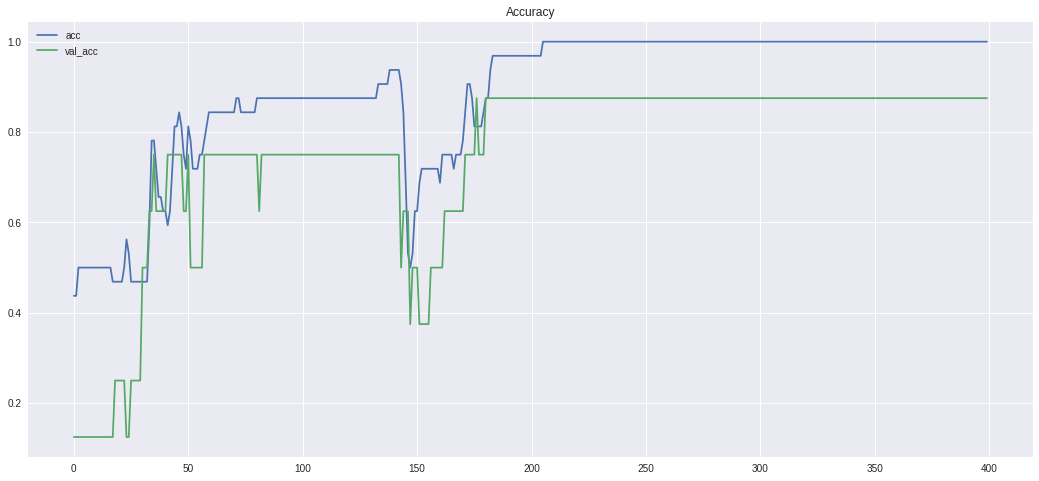

experiment:3

137 secs for training


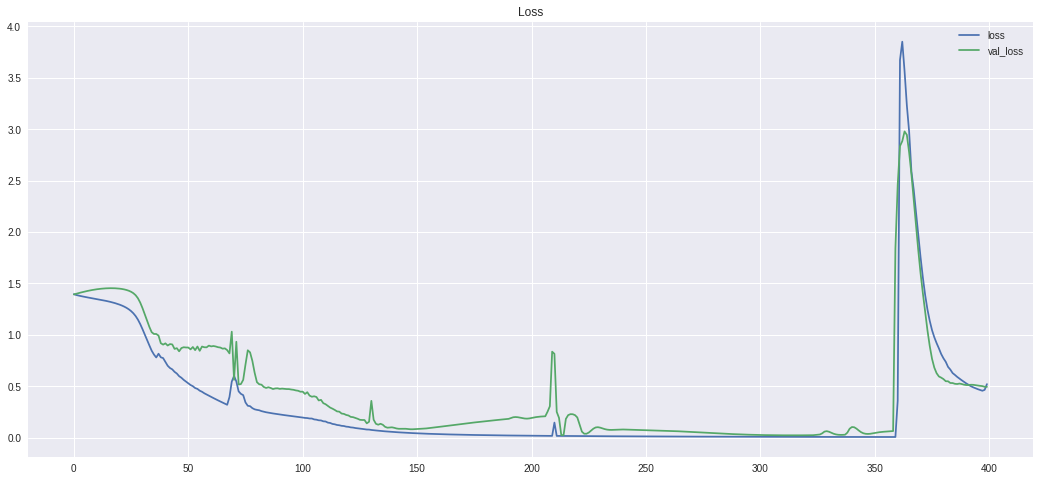

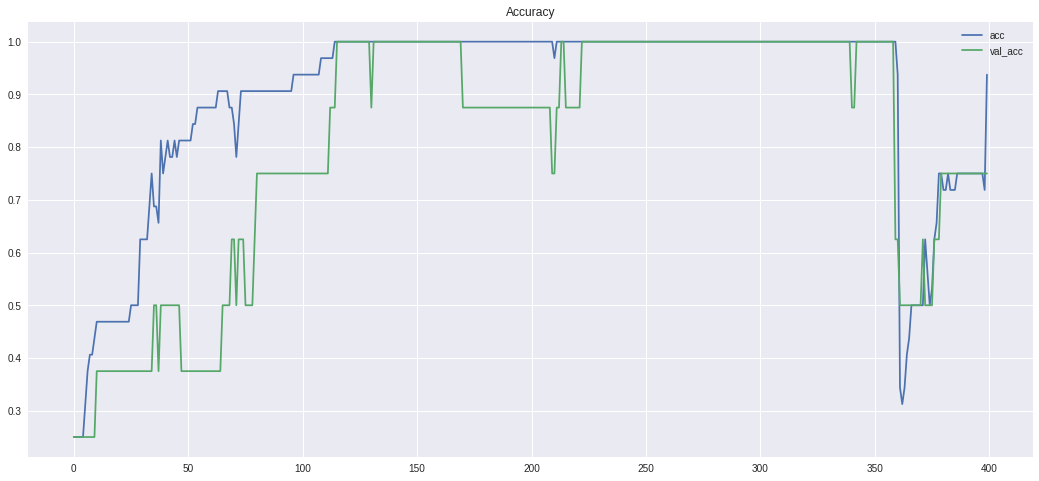

experiment:4

138 secs for training


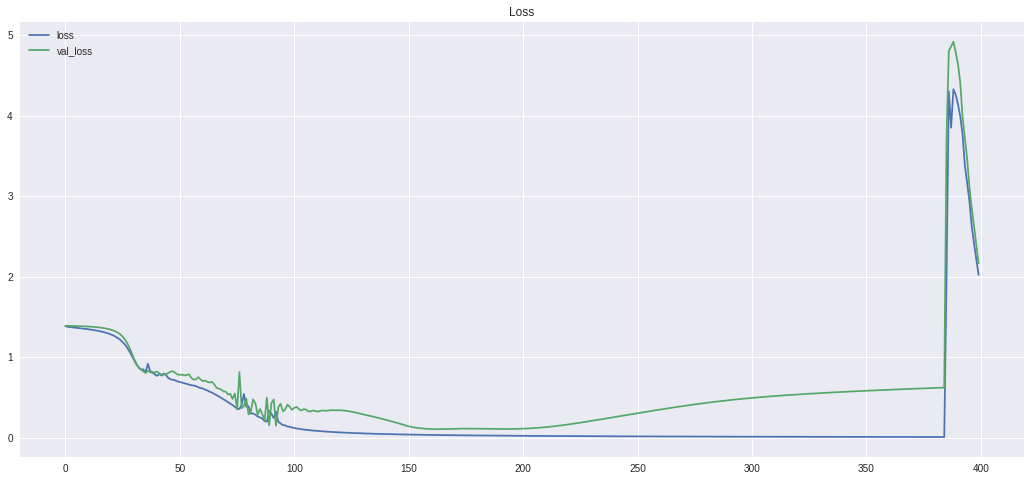

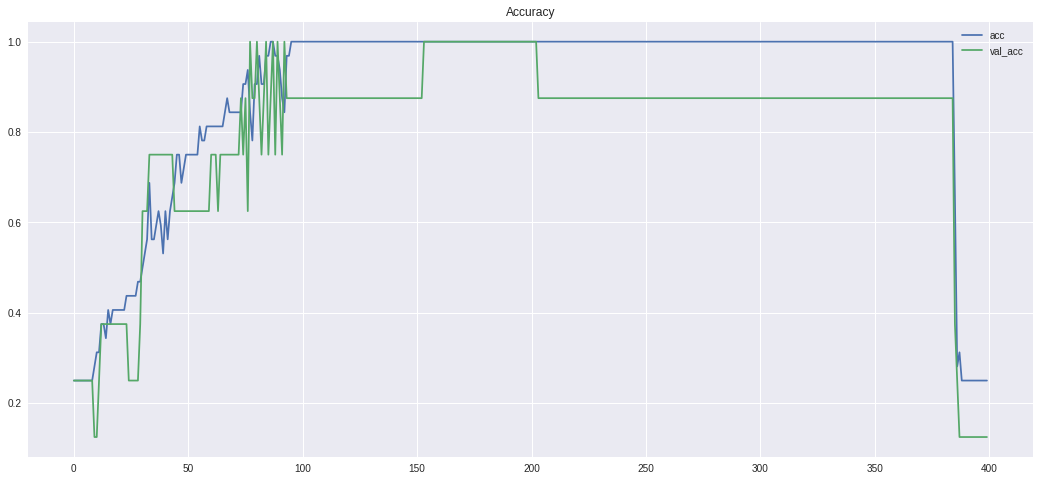

experiment:5

138 secs for training


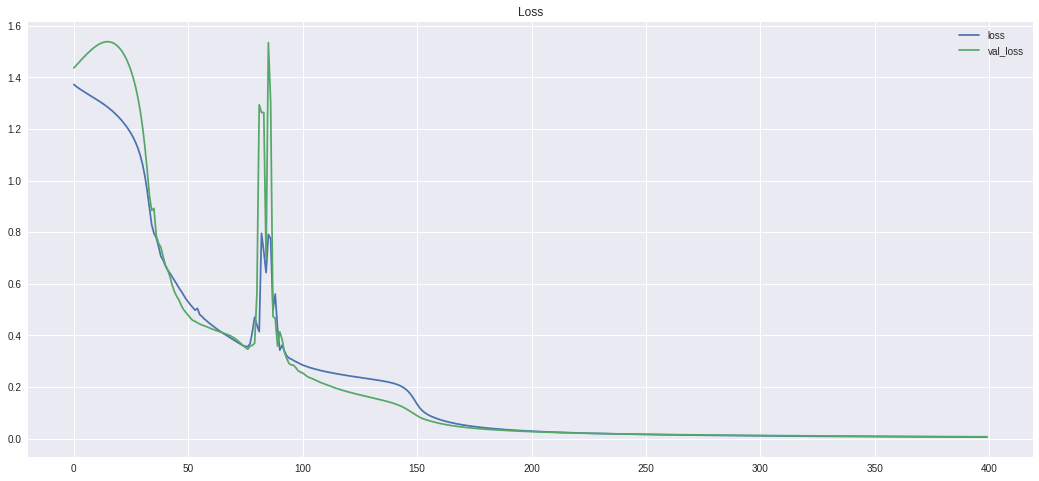

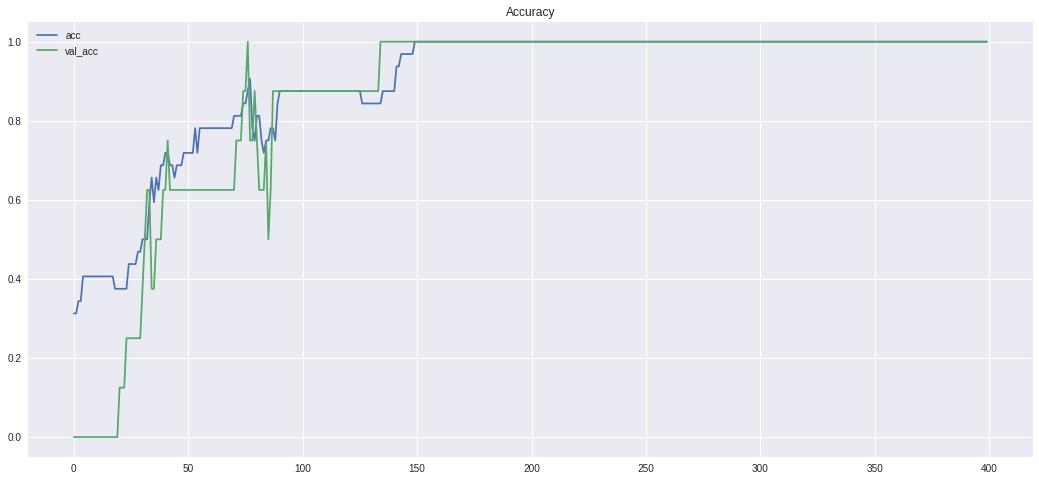

experiment:6

138 secs for training


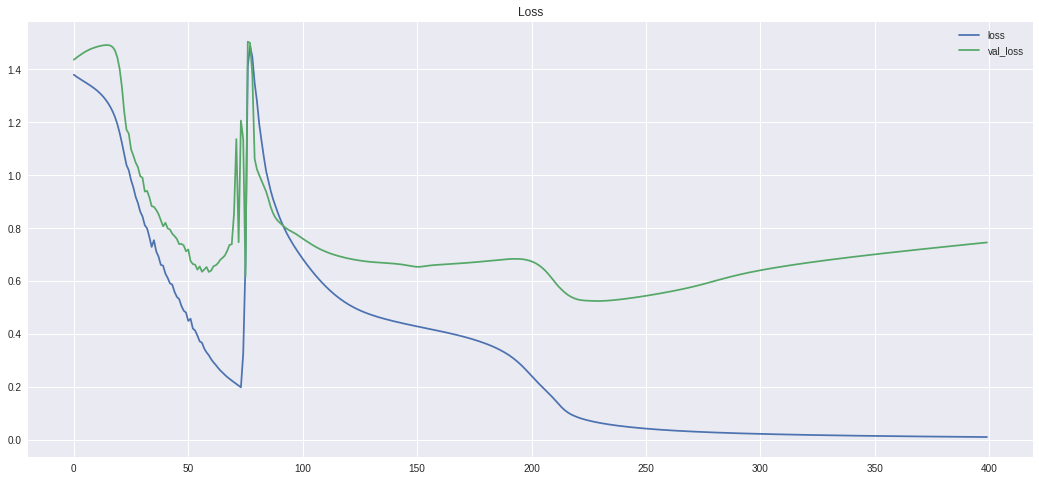

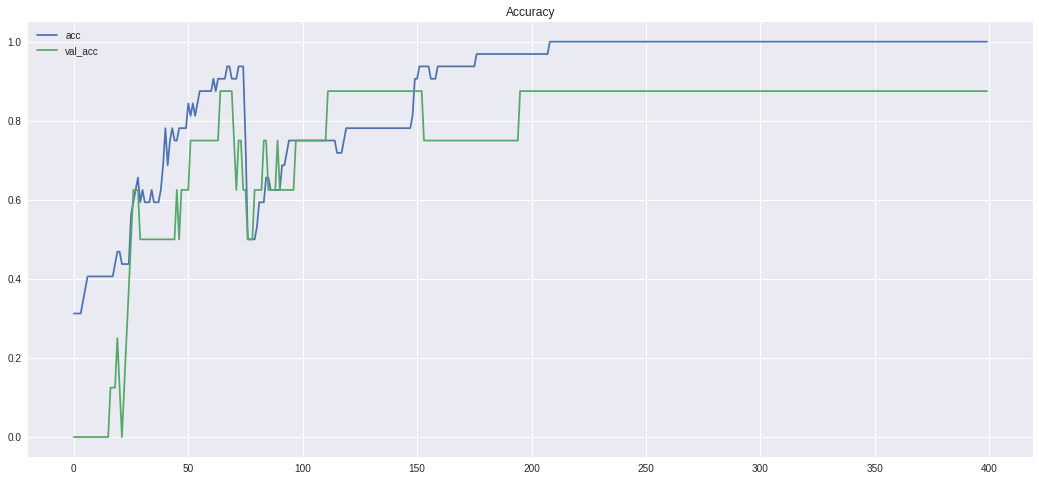

experiment:7

138 secs for training


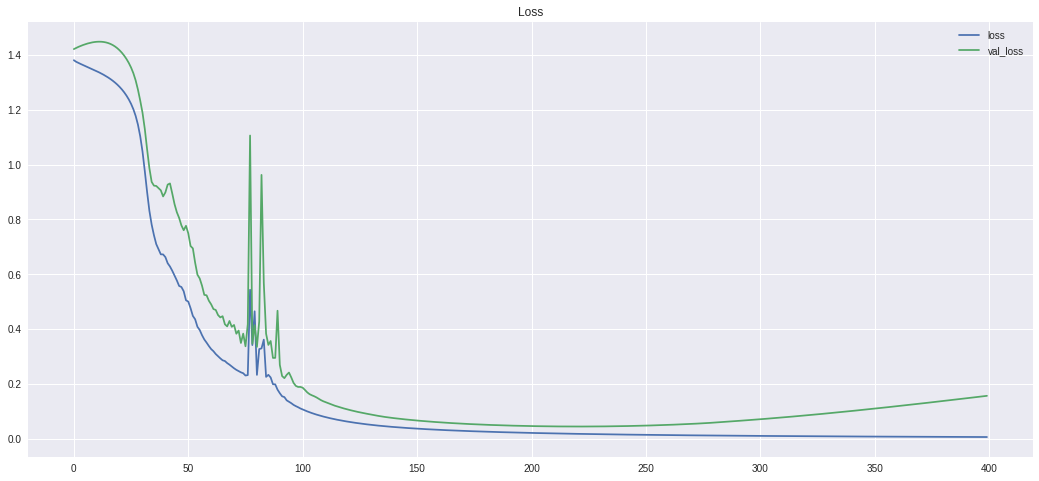

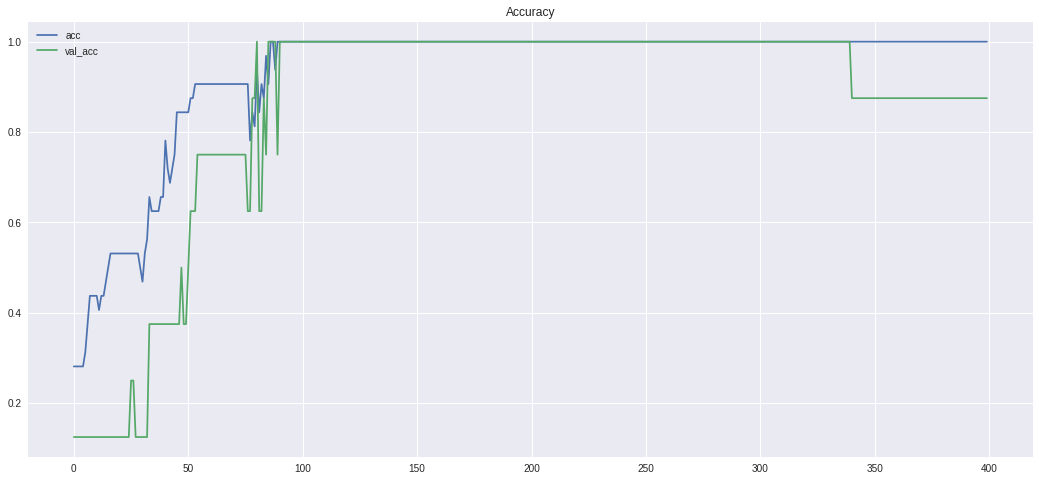

experiment:8

138 secs for training


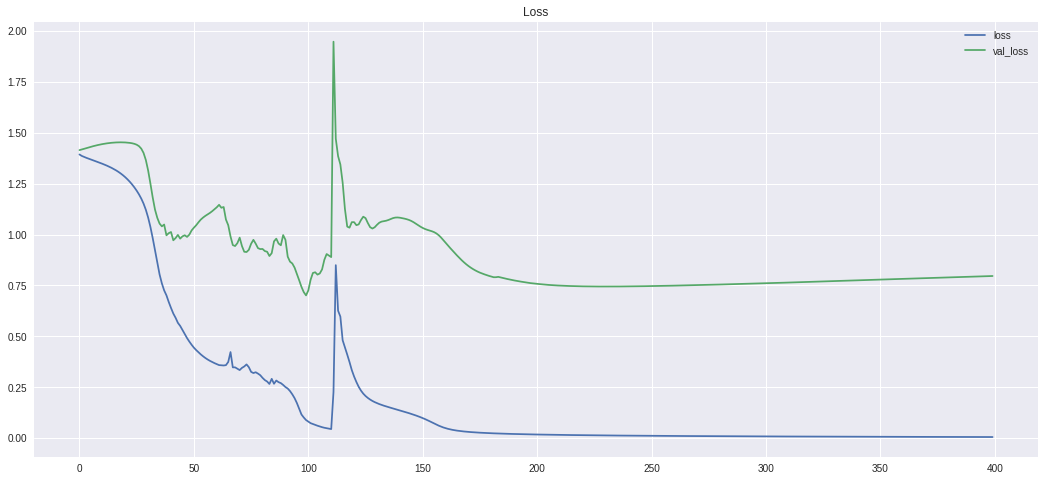

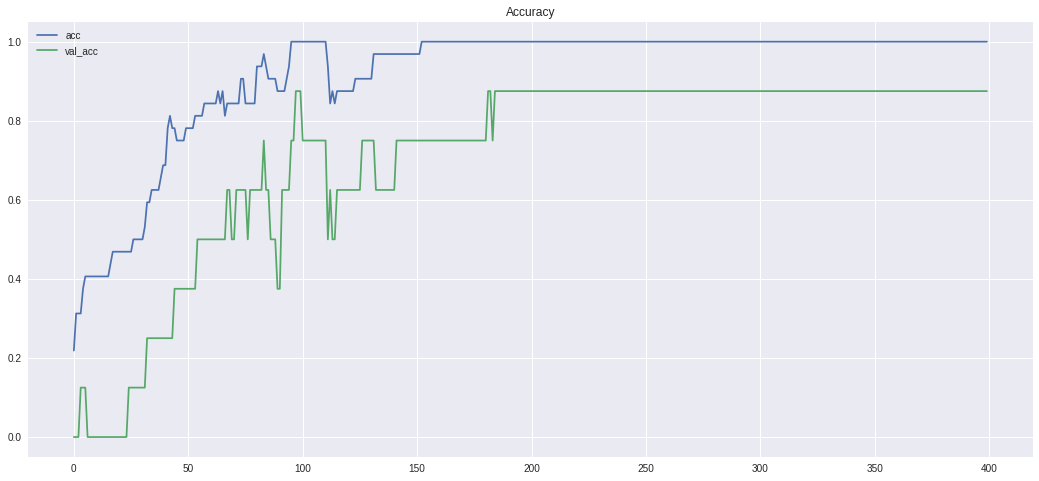

experiment:9

138 secs for training


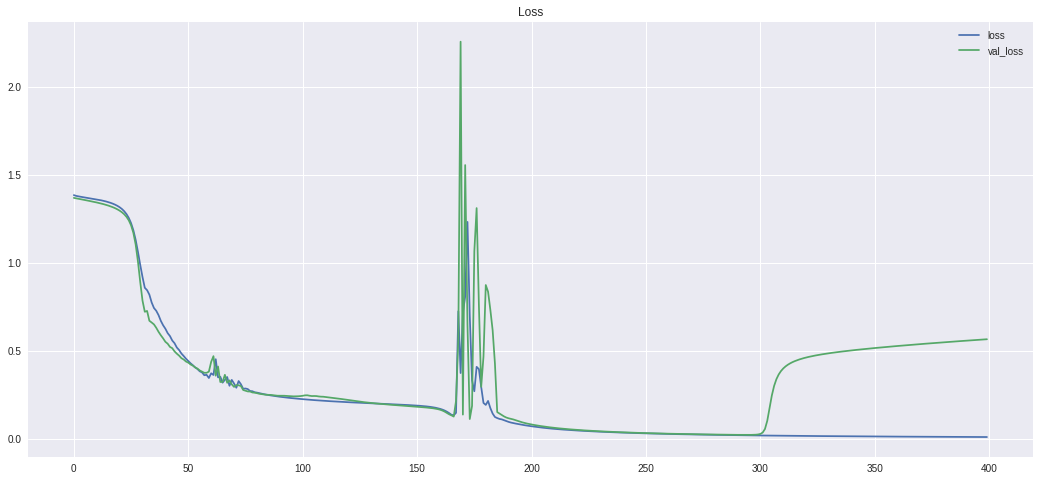

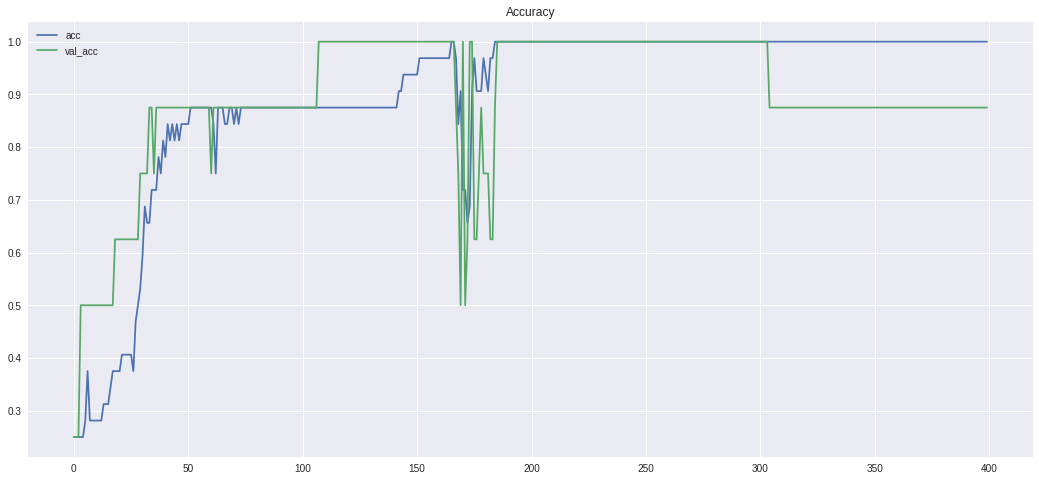

experiment:10

139 secs for training


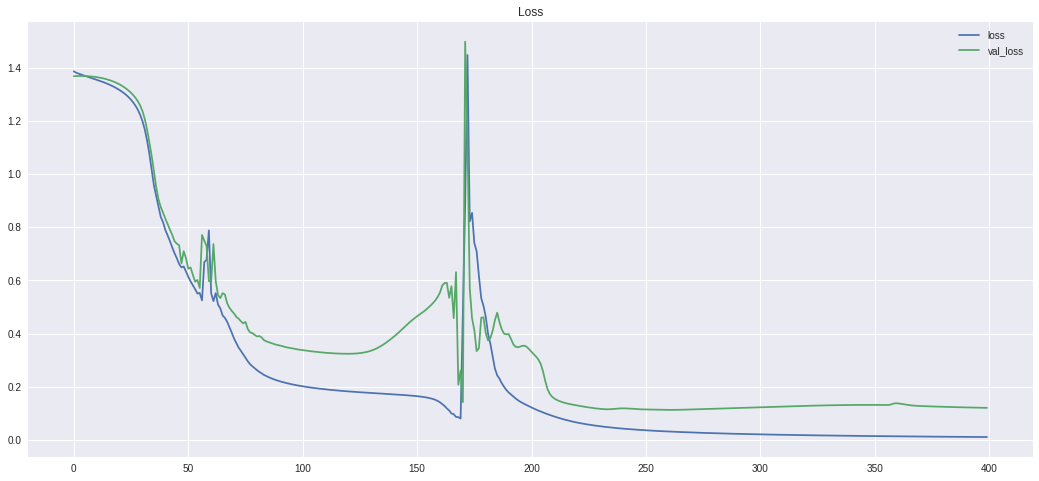

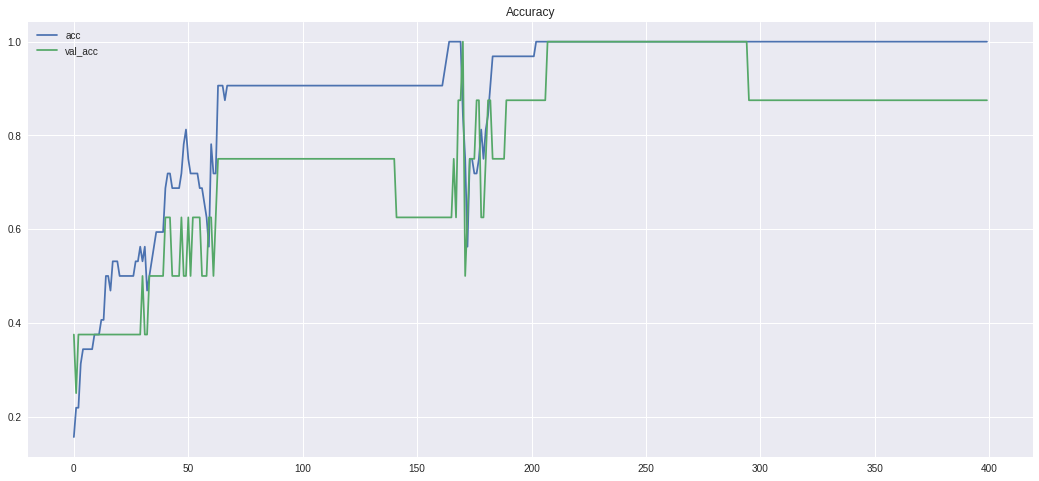

   acc_train  acc_test
0     1.0000     0.625
0     1.0000     0.875
0     0.9375     0.750
0     0.2500     0.125
0     1.0000     1.000
0     1.0000     0.875
0     1.0000     0.875
0     1.0000     0.875
0     1.0000     0.875
0     1.0000     0.875


In [32]:
acc = pd.DataFrame(columns=['acc_train','acc_test'])
for e in range(1,11):
  print("experiment:%d\n"%(e))

  y_train_ = np.zeros((32,303,4))
  y_train_[:,0,:] = y_train

  y_test_ = np.zeros((8,303,4))
  y_test_[:,0,:] = y_test

  shuffle_data[:32,:,:6] = x_train
  shuffle_data[:32,:,6:] = y_train_

  shuffle_data[32:,:,:6] = x_test
  shuffle_data[32:,:,6:] = y_test_


  while True:
    np.random.shuffle(shuffle_data)

    x_train = shuffle_data[:32,:,:6]
    x_test = shuffle_data[32:,:,:6]
    y_train = shuffle_data[:32,0,6:].reshape(32,4)
    y_test = shuffle_data[32:,0,6:].reshape(8,4)
    if np.sum(y_test[:,0]) == 2:
        if np.sum(y_test[:,1]) == 2:
            if np.sum(y_test[:,2]) == 2:
                if np.sum(y_test[:,3]) == 2:
                    break


  batch_size = 8
  timesteps = SEQ_LENGTH
  data_dim = 6


  model = Sequential()
  model.add(CuDNNLSTM(128, return_sequences=True, stateful=False,
                 batch_input_shape=(batch_size, timesteps, data_dim)))
  model.add(CuDNNLSTM(64))
  model.add(Dense(32,activation='tanh'))
  model.add(Dense(4, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001),
                  metrics=['accuracy'])

  st = time.time()

  history = model.fit(x_train, y_train,
            batch_size=batch_size, epochs=400, shuffle=False,
            validation_data=(x_test, y_test),verbose=0)
  ft = time.time()

  print("%d secs for training"%(ft-st))

  plt.figure(figsize=(18,8))
  plt.plot(history.history['loss'],label="loss")
  plt.plot(history.history['val_loss'],label="val_loss")
  plt.title("Loss")
  plt.legend()
  plt.show()

  plt.figure(figsize=(18,8))
  plt.plot(history.history['acc'],label="acc")
  plt.plot(history.history['val_acc'],label="val_acc")
  plt.title("Accuracy")
  plt.legend()
  plt.show()

  acc = acc.append(pd.DataFrame([np.array([history.history['acc'][-1],history.history['val_acc'][-1]])],columns=acc.columns))
print(acc)

# Decreasing both learning rate and hidden units of Vanilla LSTM to prevent overfitting

experiment:1

120 secs for training


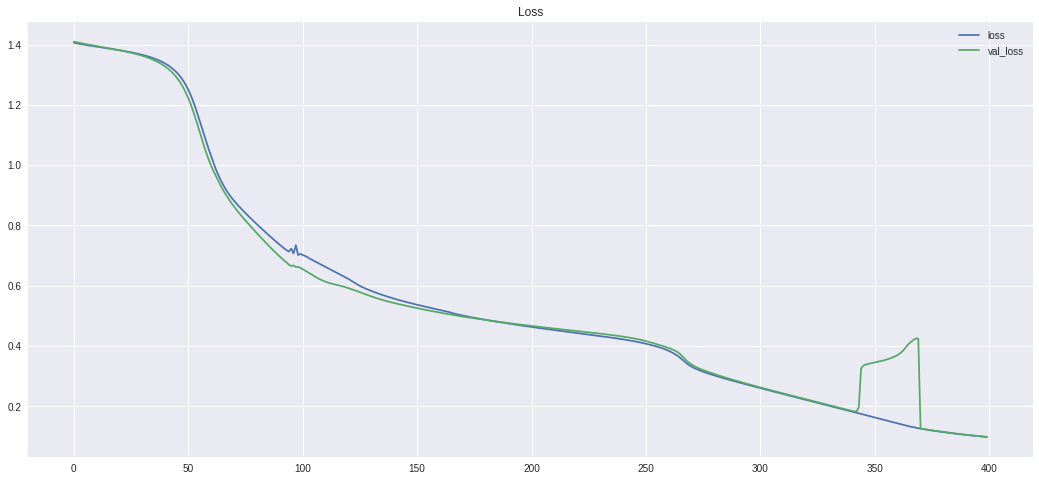

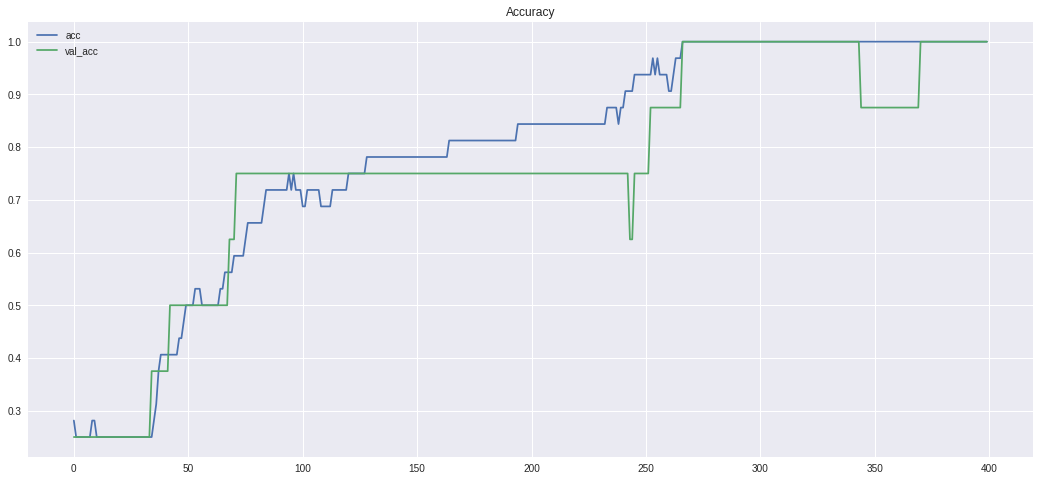

experiment:2

120 secs for training


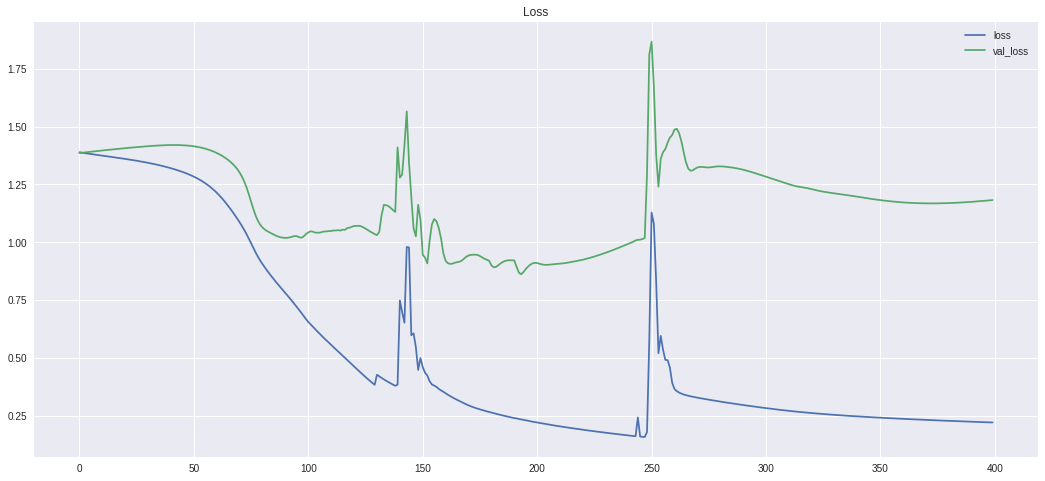

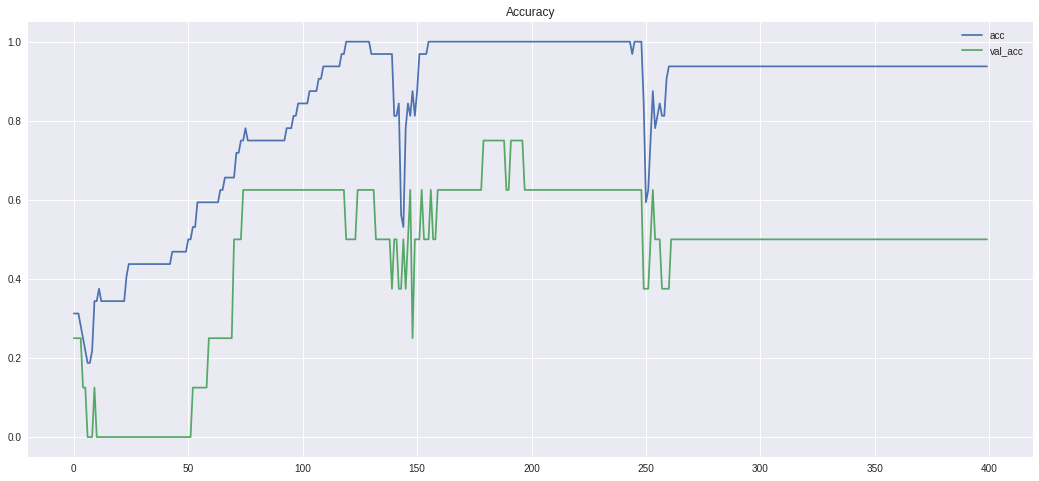

experiment:3

120 secs for training


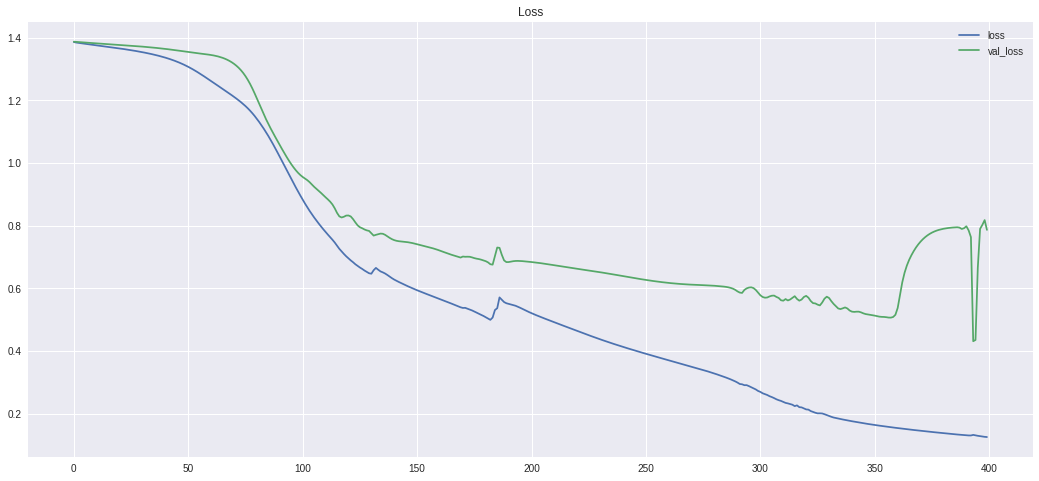

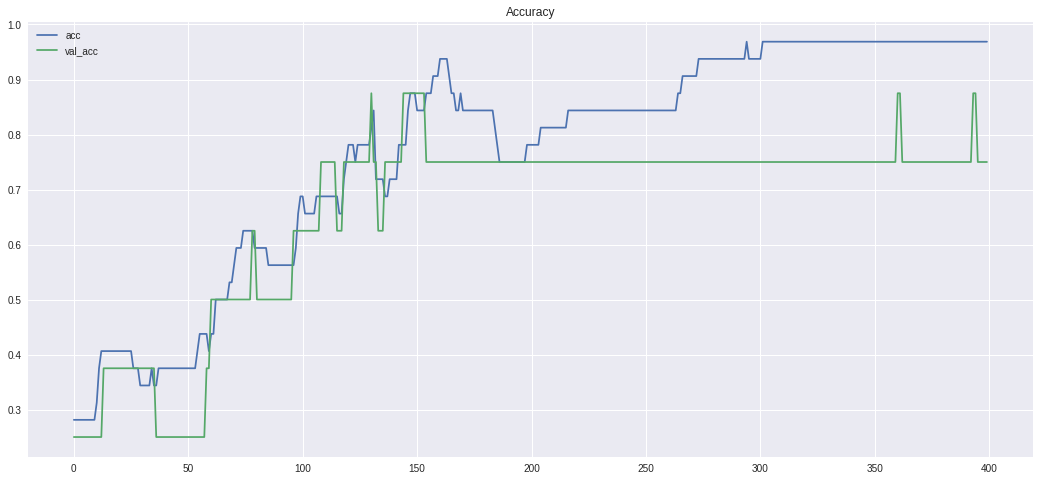

experiment:4

120 secs for training


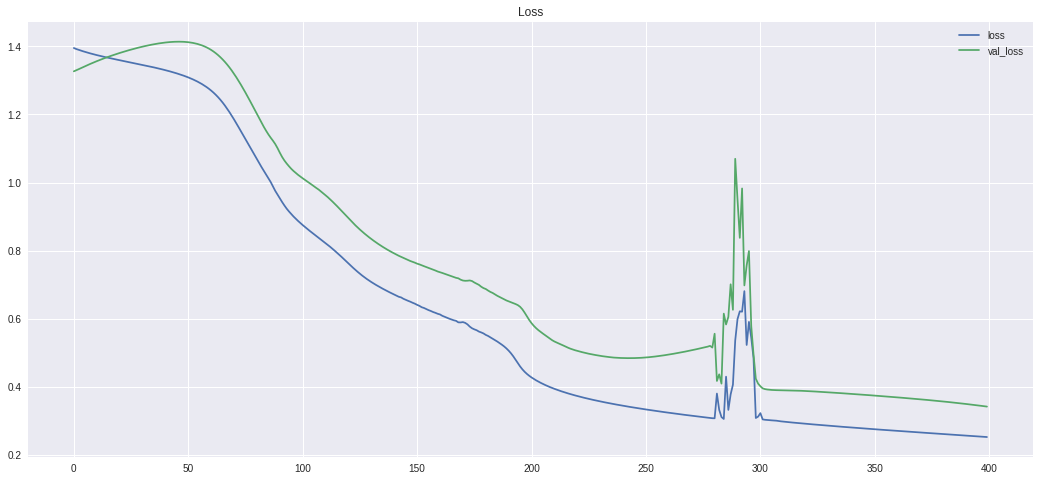

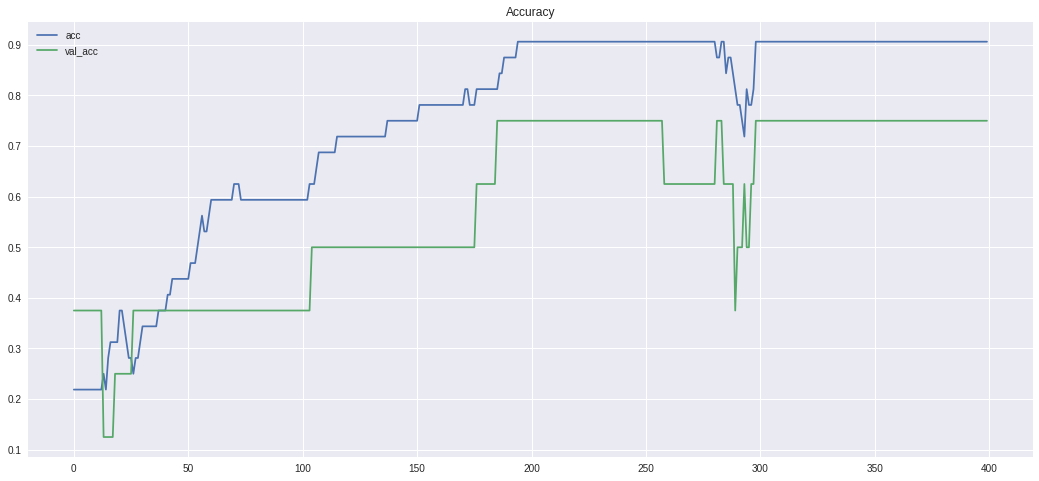

experiment:5

121 secs for training


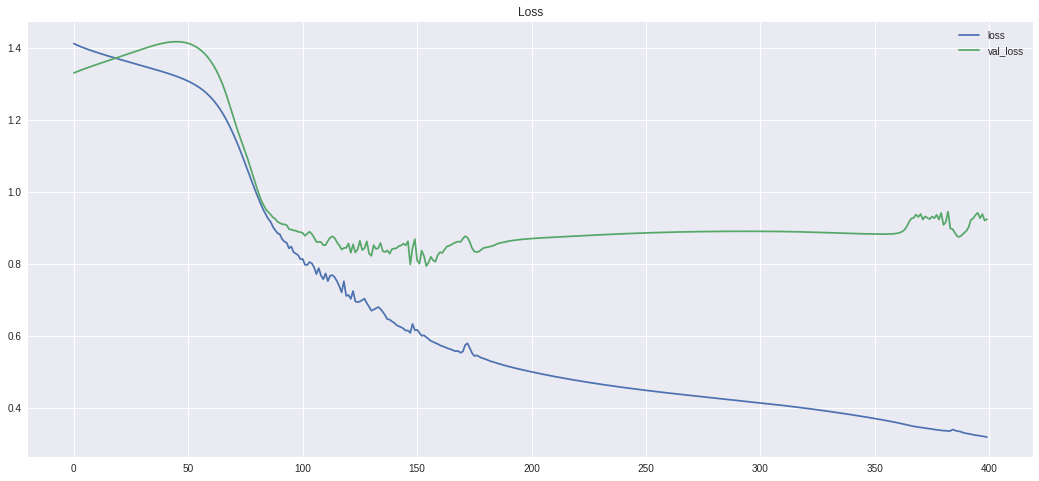

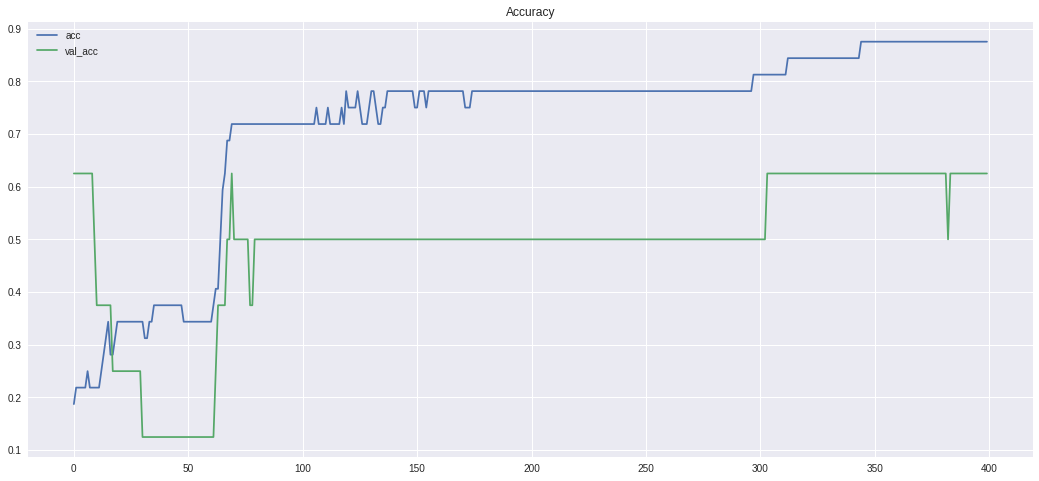

experiment:6

121 secs for training


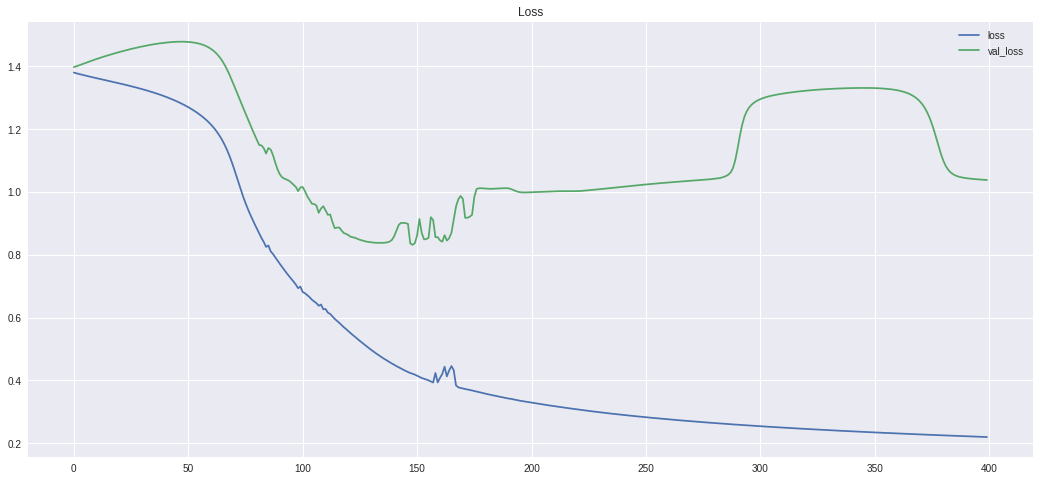

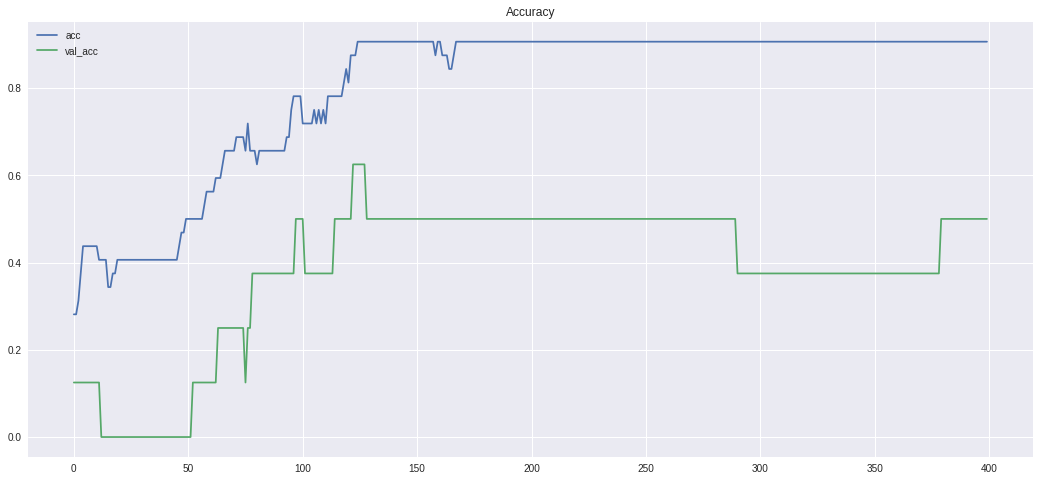

experiment:7

121 secs for training


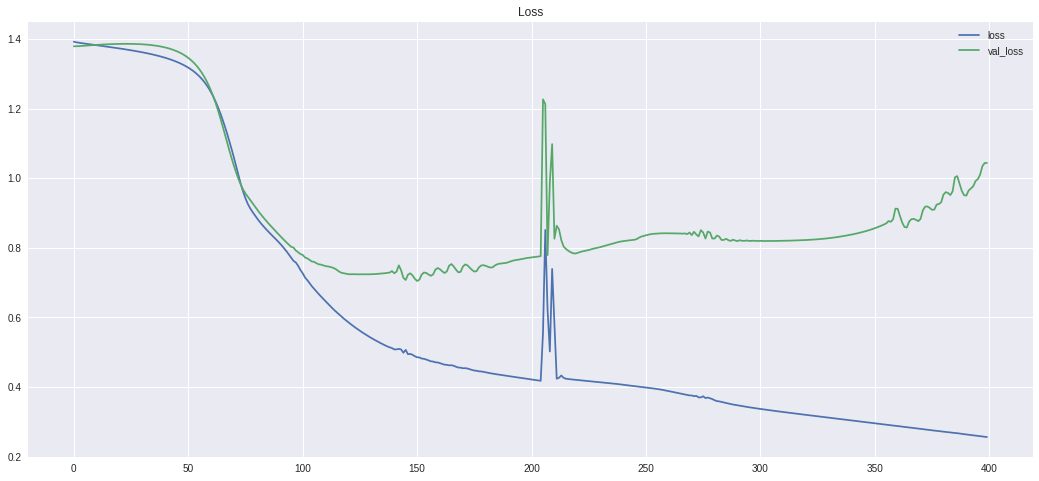

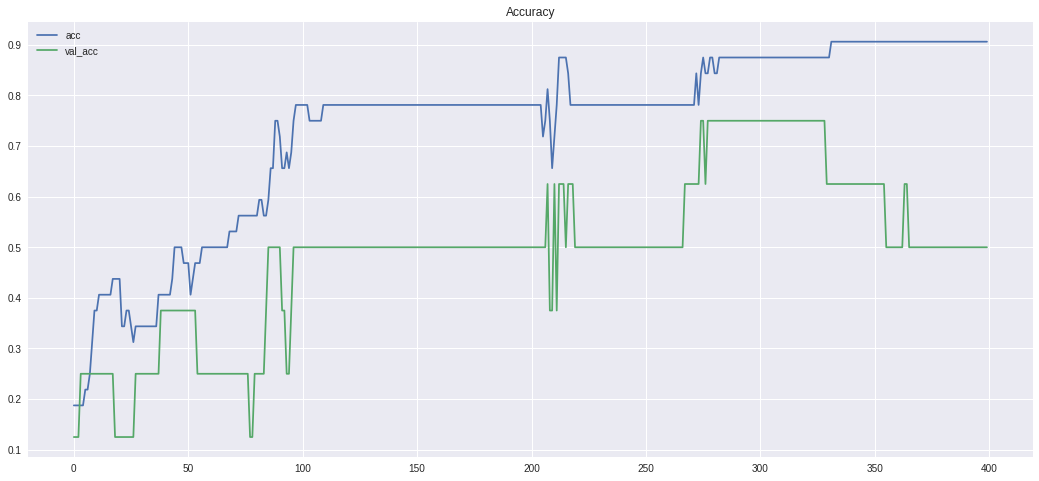

experiment:8

121 secs for training


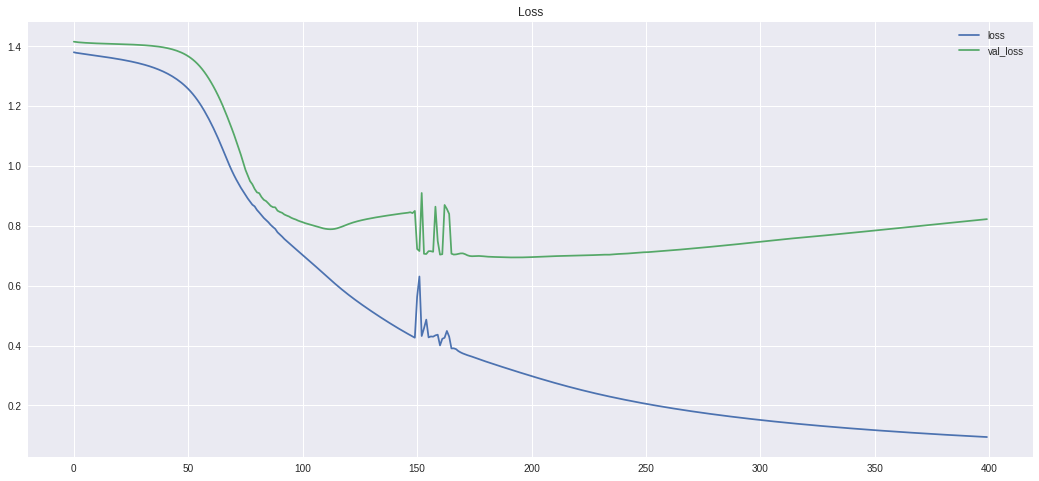

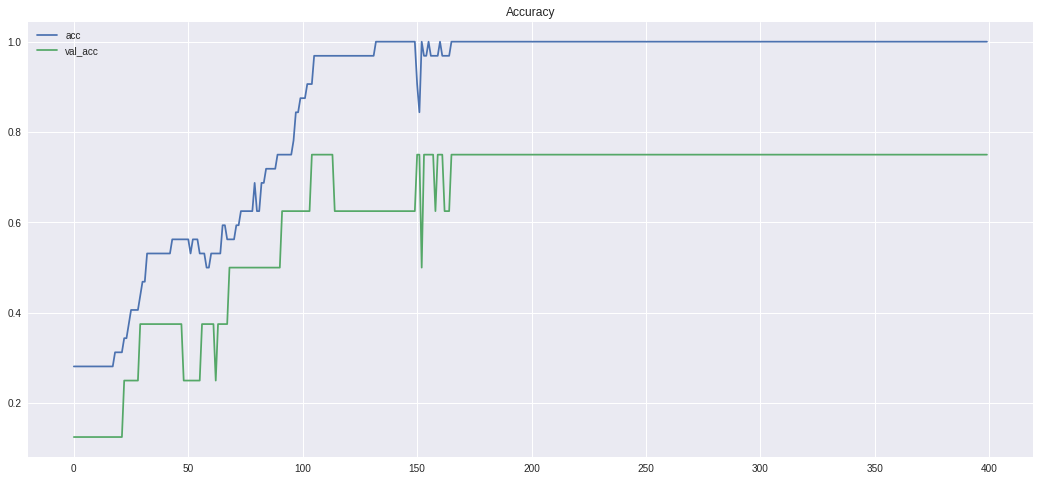

experiment:9

121 secs for training


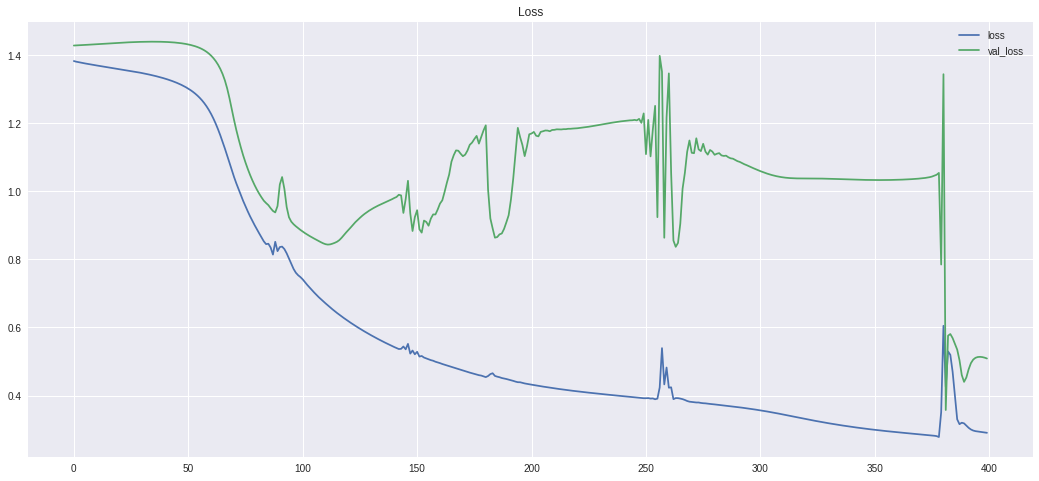

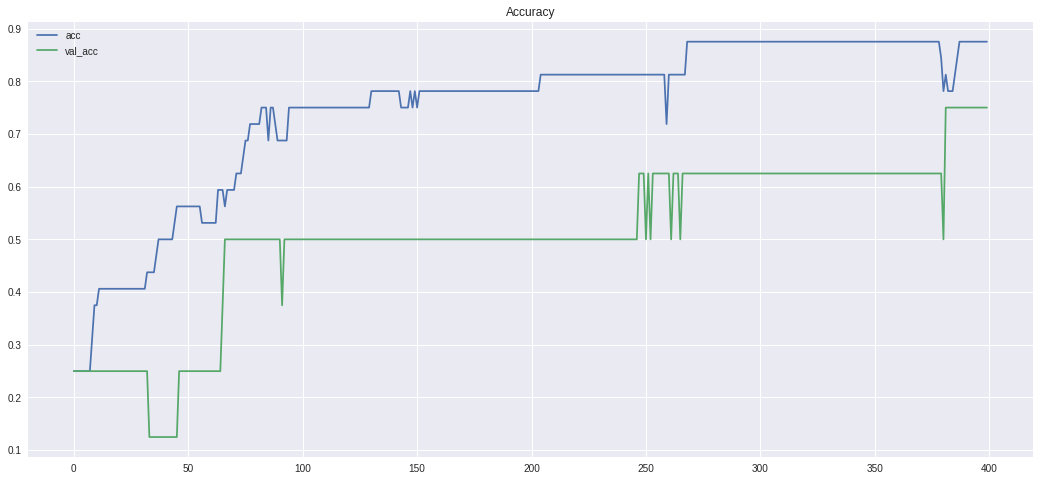

experiment:10

120 secs for training


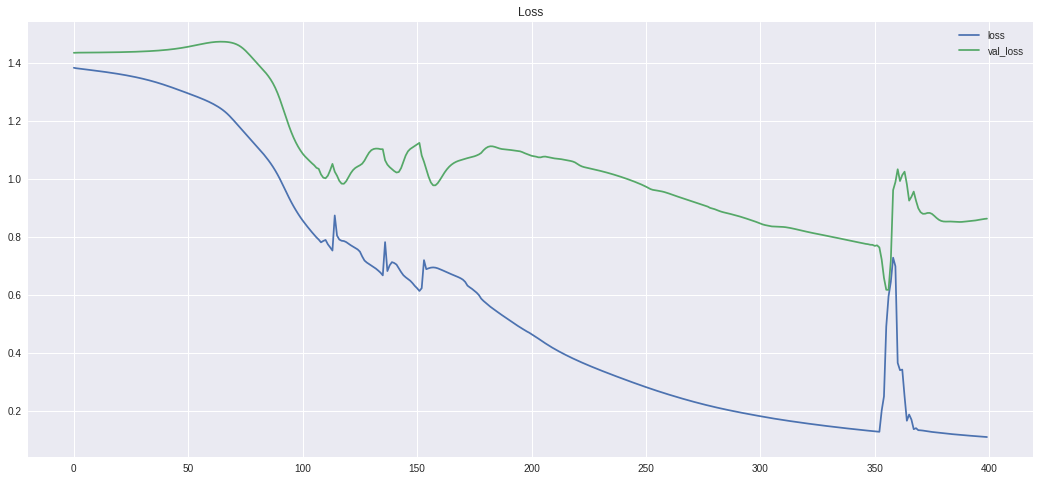

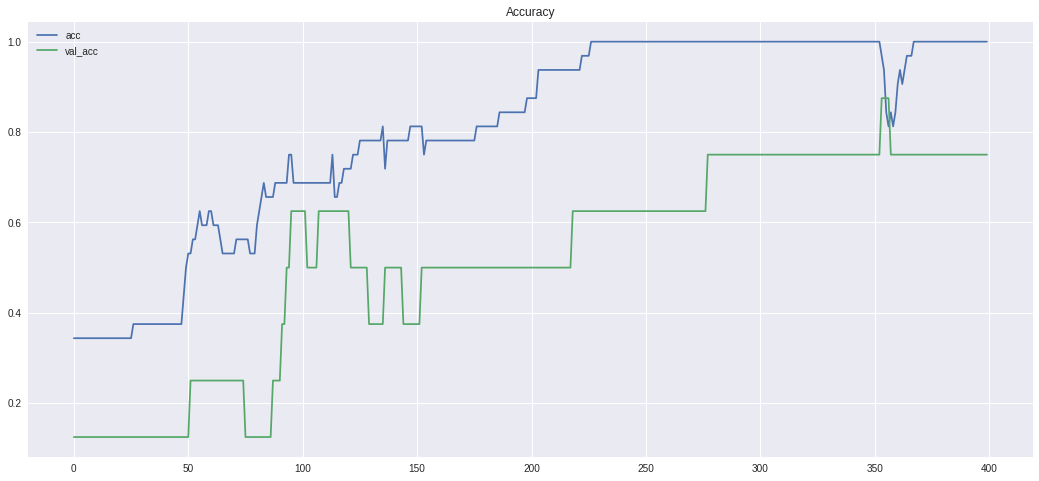

   acc_train  acc_test
0    1.00000     1.000
0    0.93750     0.500
0    0.96875     0.750
0    0.90625     0.750
0    0.87500     0.625
0    0.90625     0.500
0    0.90625     0.500
0    1.00000     0.750
0    0.87500     0.750
0    1.00000     0.750


In [33]:
acc = pd.DataFrame(columns=['acc_train','acc_test'])
for e in range(1,11):
  print("experiment:%d\n"%(e))

  y_train_ = np.zeros((32,303,4))
  y_train_[:,0,:] = y_train

  y_test_ = np.zeros((8,303,4))
  y_test_[:,0,:] = y_test

  shuffle_data[:32,:,:6] = x_train
  shuffle_data[:32,:,6:] = y_train_

  shuffle_data[32:,:,:6] = x_test
  shuffle_data[32:,:,6:] = y_test_


  while True:
    np.random.shuffle(shuffle_data)

    x_train = shuffle_data[:32,:,:6]
    x_test = shuffle_data[32:,:,:6]
    y_train = shuffle_data[:32,0,6:].reshape(32,4)
    y_test = shuffle_data[32:,0,6:].reshape(8,4)
    if np.sum(y_test[:,0]) == 2:
        if np.sum(y_test[:,1]) == 2:
            if np.sum(y_test[:,2]) == 2:
                if np.sum(y_test[:,3]) == 2:
                    break


  batch_size = 8
  timesteps = SEQ_LENGTH
  data_dim = 6


  model = Sequential()
  model.add(CuDNNLSTM(36, return_sequences=True, stateful=False,
                 batch_input_shape=(batch_size, timesteps, data_dim)))
  model.add(CuDNNLSTM(24))
  model.add(Dense(12,activation='tanh'))
  model.add(Dense(4, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001),
                  metrics=['accuracy'])

  st = time.time()

  history = model.fit(x_train, y_train,
            batch_size=batch_size, epochs=400, shuffle=False,
            validation_data=(x_test, y_test),verbose=0)
  ft = time.time()

  print("%d secs for training"%(ft-st))

  plt.figure(figsize=(18,8))
  plt.plot(history.history['loss'],label="loss")
  plt.plot(history.history['val_loss'],label="val_loss")
  plt.title("Loss")
  plt.legend()
  plt.show()

  plt.figure(figsize=(18,8))
  plt.plot(history.history['acc'],label="acc")
  plt.plot(history.history['val_acc'],label="val_acc")
  plt.title("Accuracy")
  plt.legend()
  plt.show()

  acc = acc.append(pd.DataFrame([np.array([history.history['acc'][-1],history.history['val_acc'][-1]])],columns=acc.columns))
print(acc)

# Adding Dropout between stacked LSTM layers

experiment:1

121 secs for training


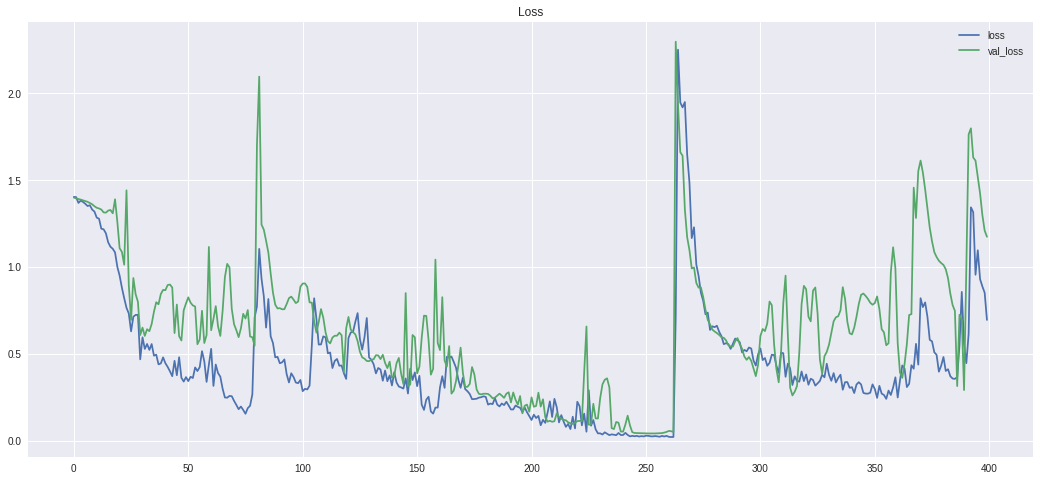

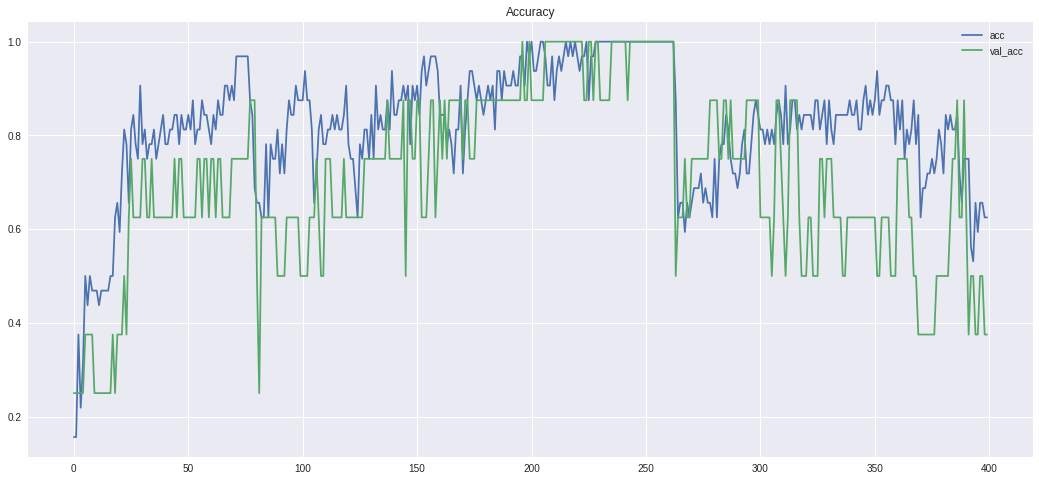

experiment:2

122 secs for training


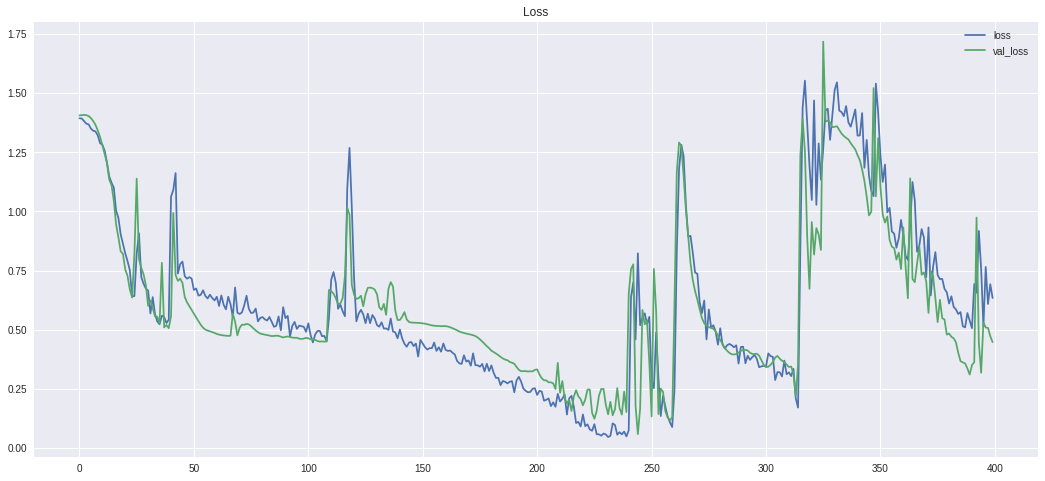

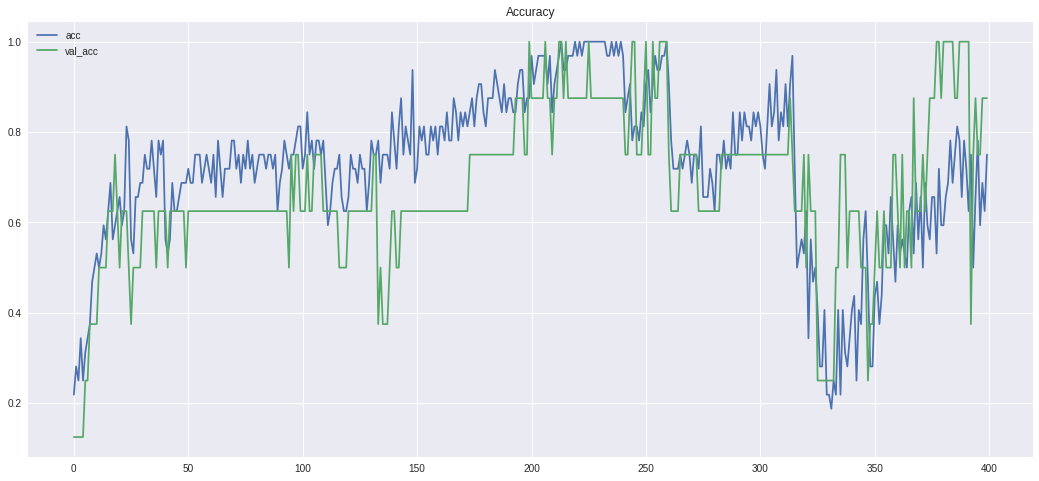

experiment:3

122 secs for training


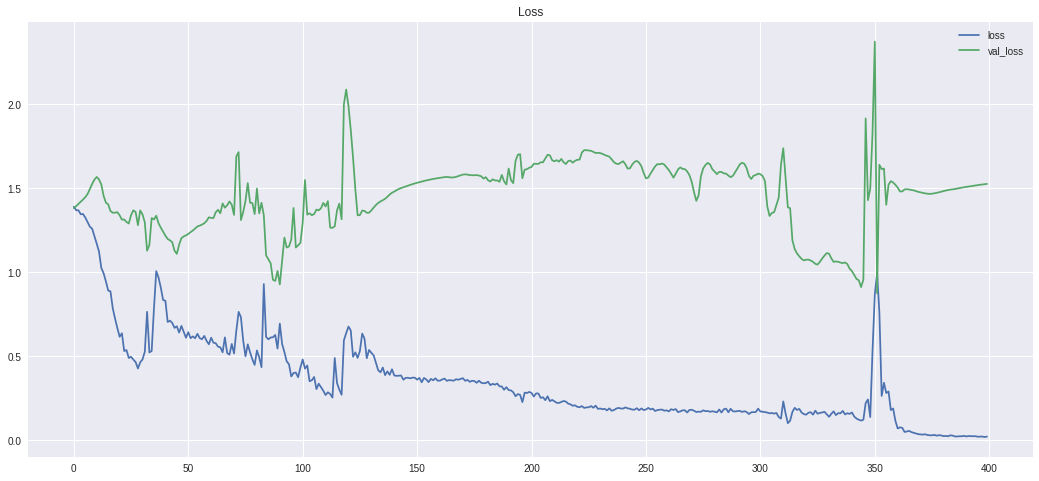

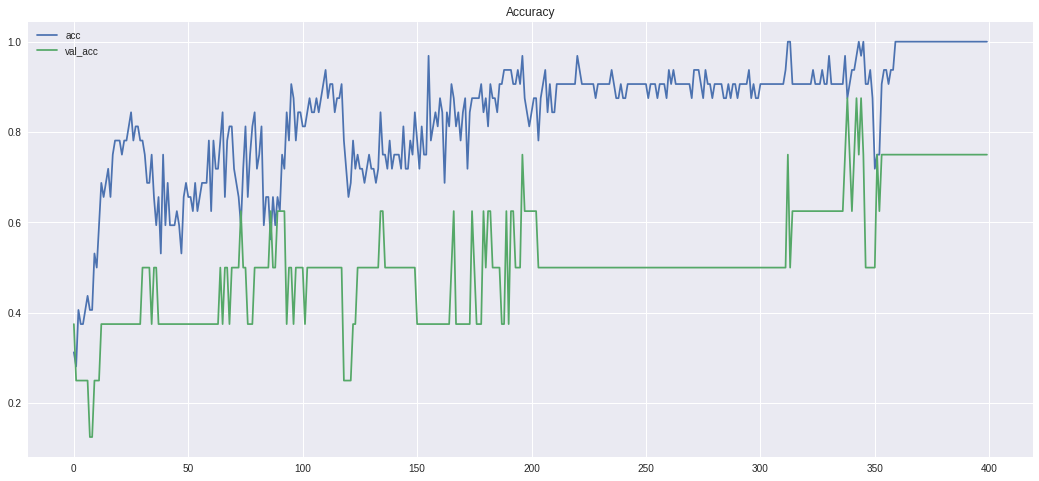

experiment:4

122 secs for training


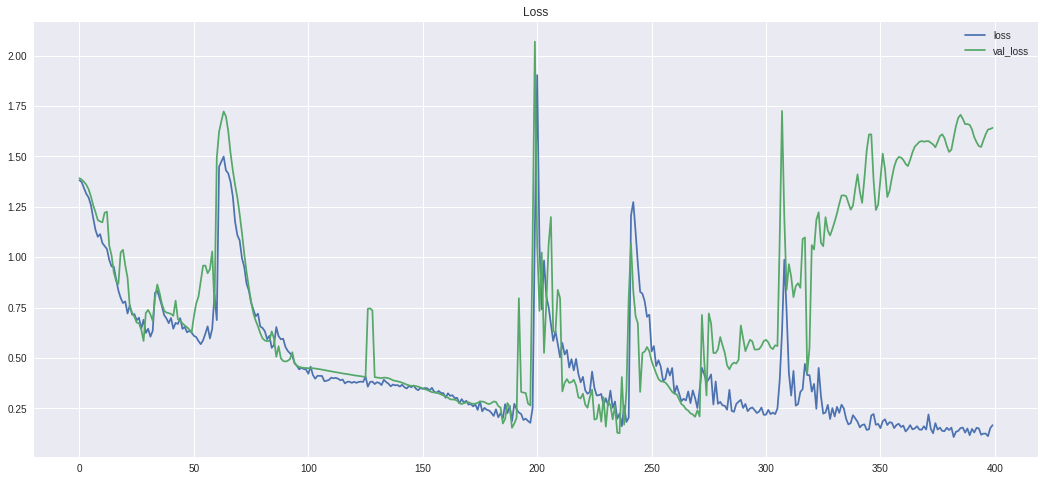

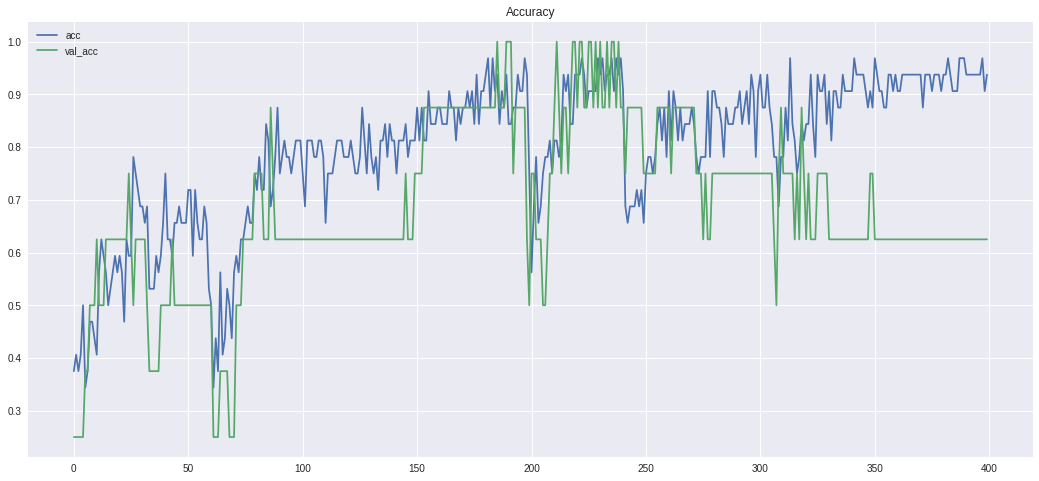

experiment:5

122 secs for training


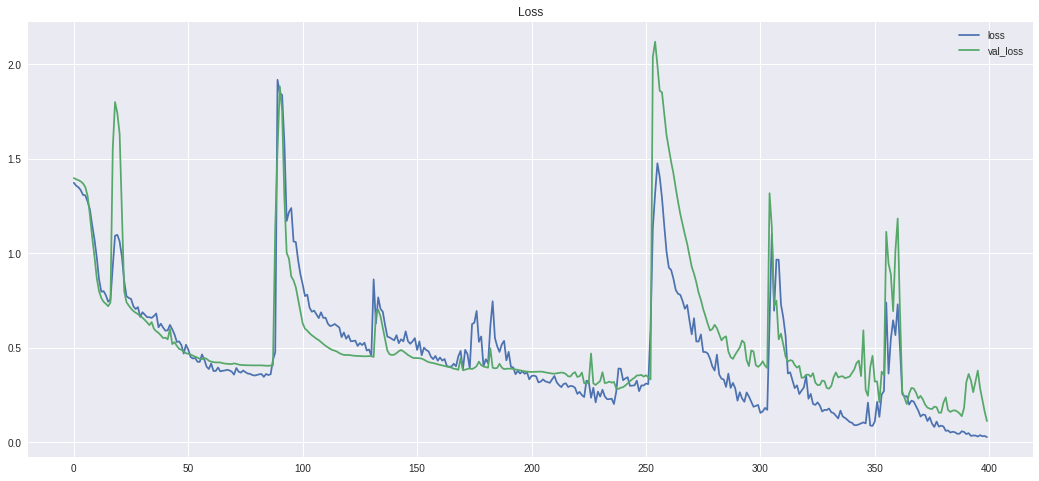

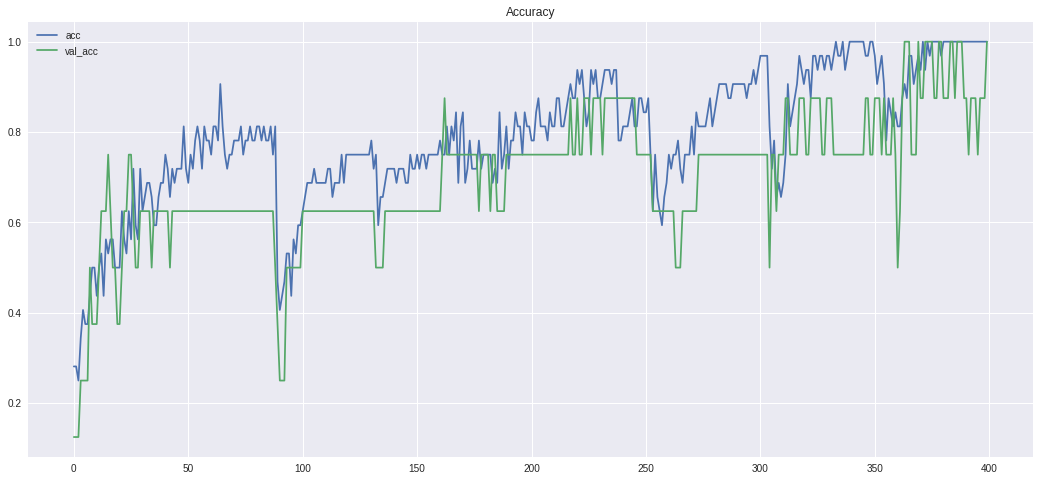

experiment:6

123 secs for training


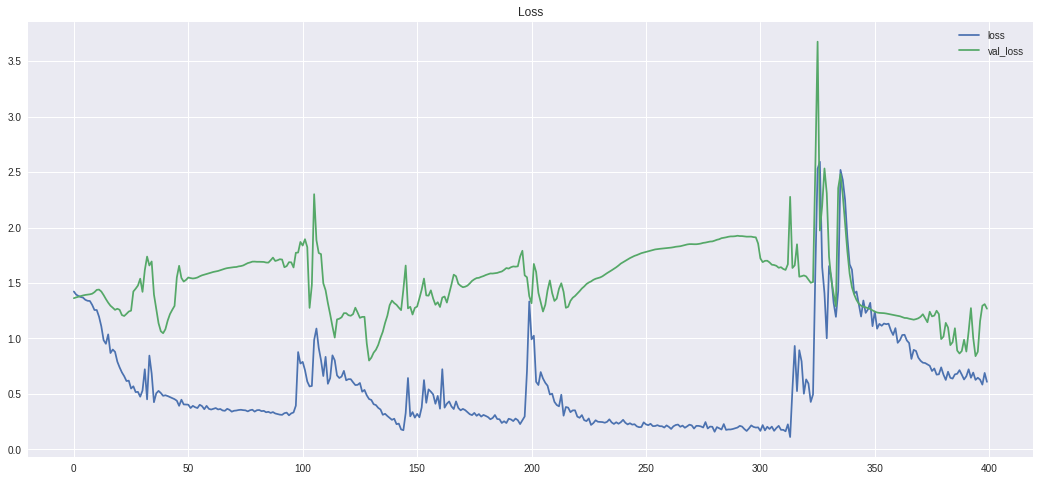

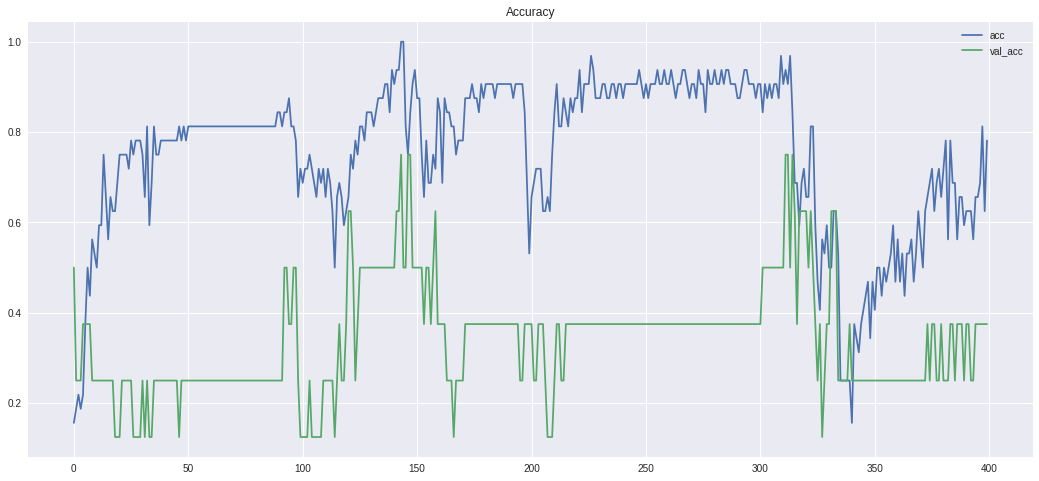

experiment:7

123 secs for training


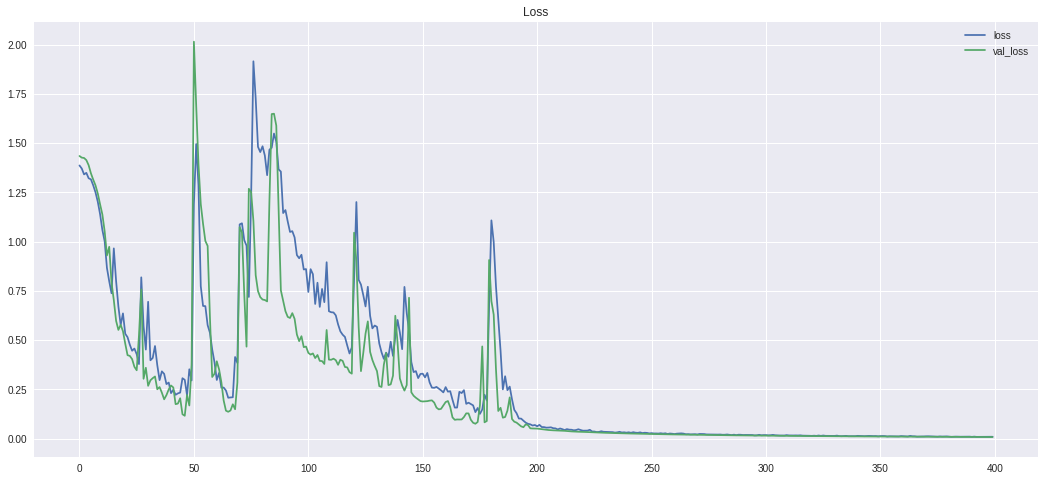

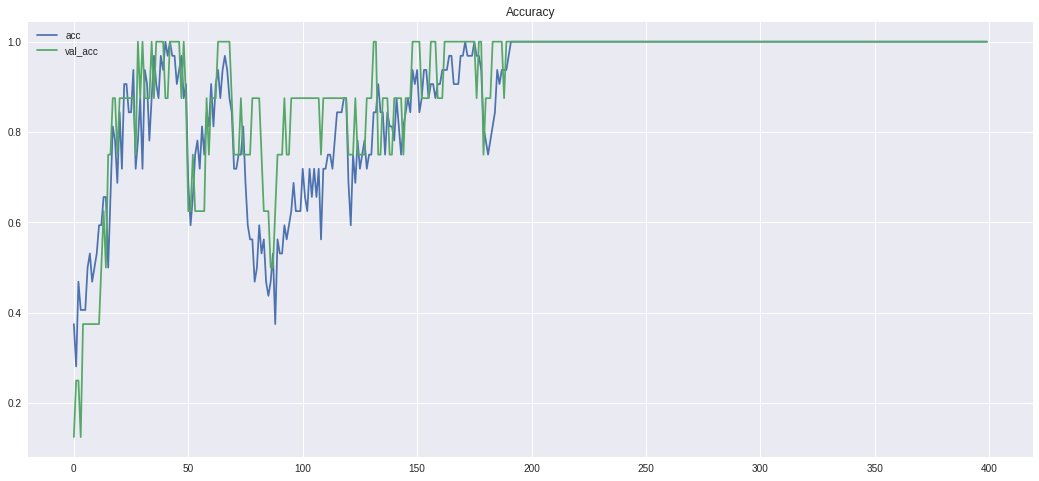

experiment:8

124 secs for training


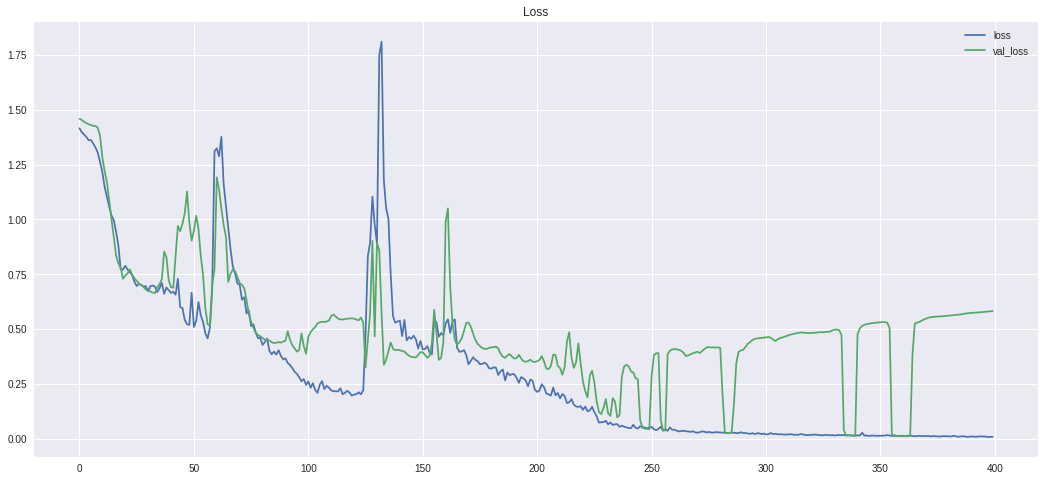

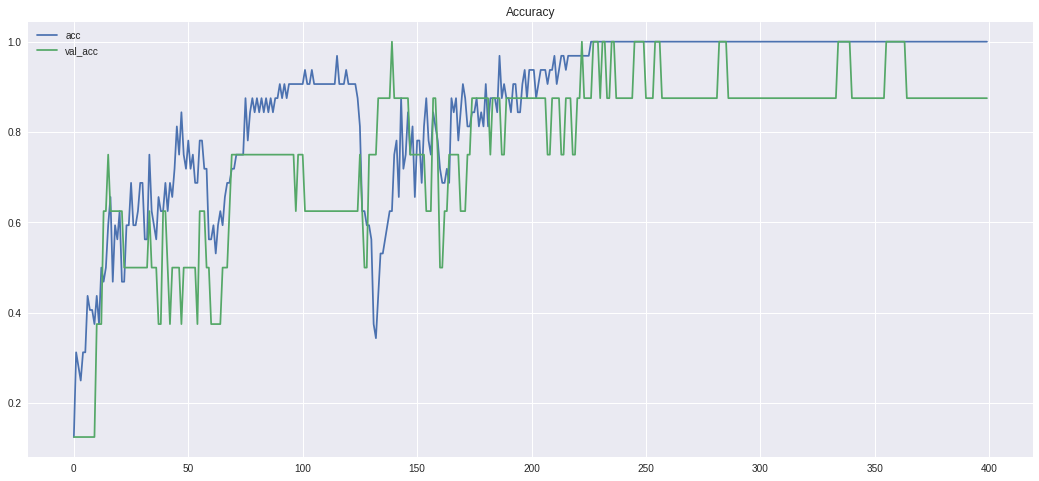

experiment:9

123 secs for training


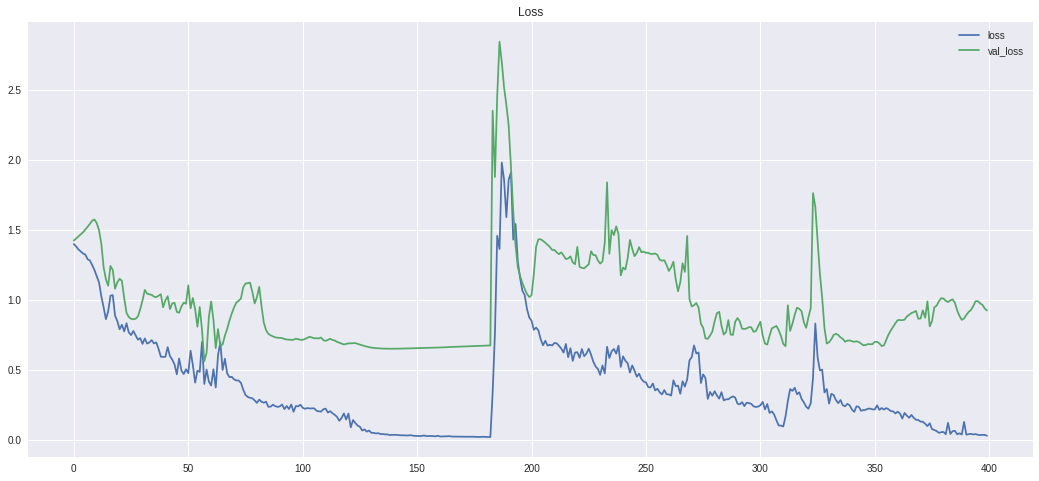

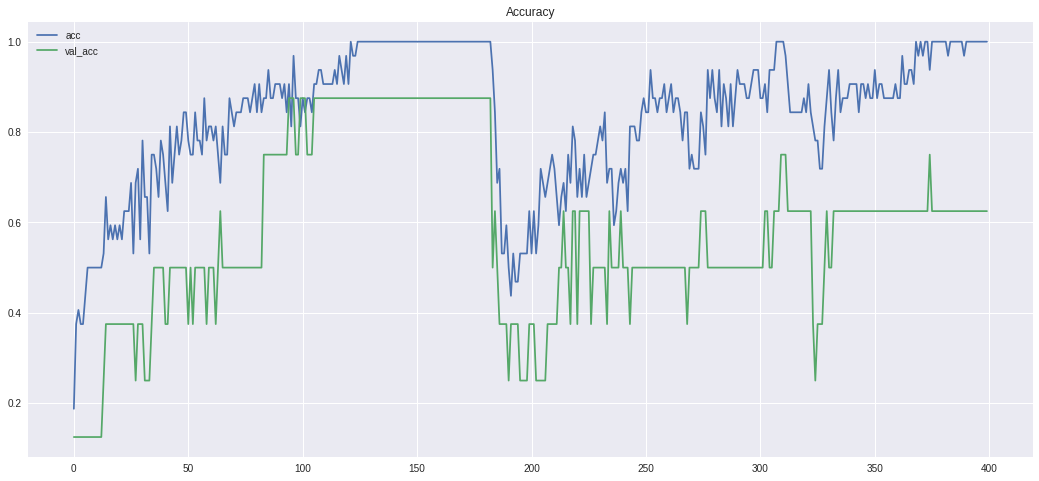

experiment:10

124 secs for training


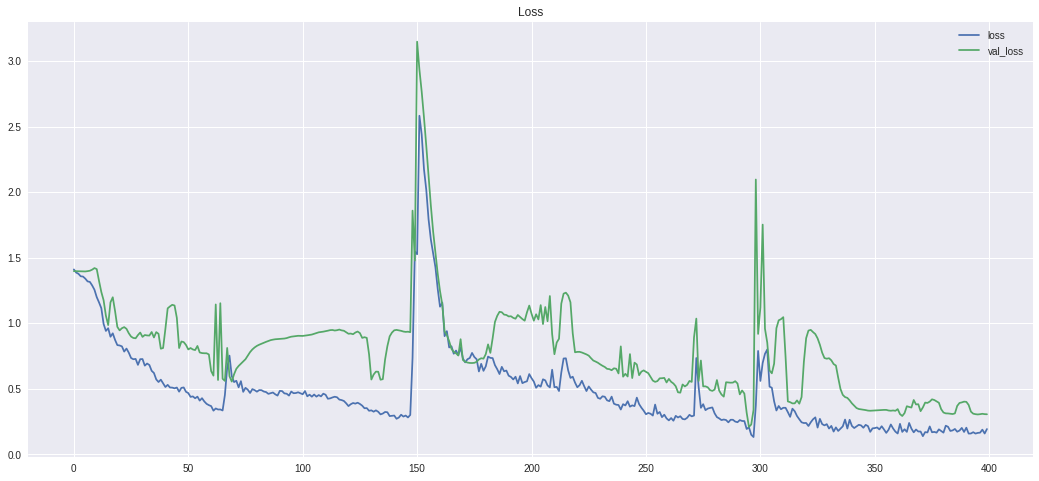

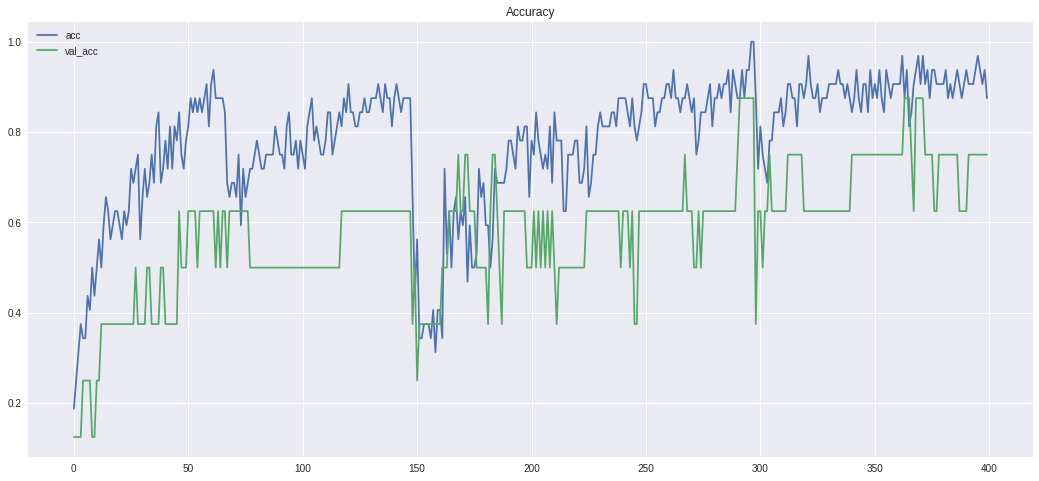

   acc_train  acc_test
0    0.62500     0.375
0    0.75000     0.875
0    1.00000     0.750
0    0.93750     0.625
0    1.00000     1.000
0    0.78125     0.375
0    1.00000     1.000
0    1.00000     0.875
0    1.00000     0.625
0    0.87500     0.750


In [36]:
acc = pd.DataFrame(columns=['acc_train','acc_test'])
for e in range(1,11):
  print("experiment:%d\n"%(e))

  y_train_ = np.zeros((32,303,4))
  y_train_[:,0,:] = y_train

  y_test_ = np.zeros((8,303,4))
  y_test_[:,0,:] = y_test

  shuffle_data[:32,:,:6] = x_train
  shuffle_data[:32,:,6:] = y_train_

  shuffle_data[32:,:,:6] = x_test
  shuffle_data[32:,:,6:] = y_test_


  while True:
    np.random.shuffle(shuffle_data)

    x_train = shuffle_data[:32,:,:6]
    x_test = shuffle_data[32:,:,:6]
    y_train = shuffle_data[:32,0,6:].reshape(32,4)
    y_test = shuffle_data[32:,0,6:].reshape(8,4)
    if np.sum(y_test[:,0]) == 2:
        if np.sum(y_test[:,1]) == 2:
            if np.sum(y_test[:,2]) == 2:
                if np.sum(y_test[:,3]) == 2:
                    break


  batch_size = 8
  timesteps = SEQ_LENGTH
  data_dim = 6


  model = Sequential()
  model.add(CuDNNLSTM(36, return_sequences=True, stateful=False,
                 batch_input_shape=(batch_size, timesteps, data_dim)))
  model.add(Dropout(0.1))
  model.add(CuDNNLSTM(24))
  model.add(Dropout(0.1))
  model.add(Dense(12,activation='tanh'))
  model.add(Dense(4, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])

  st = time.time()

  history = model.fit(x_train, y_train,
            batch_size=batch_size, epochs=400, shuffle=False,
            validation_data=(x_test, y_test),verbose=0)
  ft = time.time()

  print("%d secs for training"%(ft-st))

  plt.figure(figsize=(18,8))
  plt.plot(history.history['loss'],label="loss")
  plt.plot(history.history['val_loss'],label="val_loss")
  plt.title("Loss")
  plt.legend()
  plt.show()

  plt.figure(figsize=(18,8))
  plt.plot(history.history['acc'],label="acc")
  plt.plot(history.history['val_acc'],label="val_acc")
  plt.title("Accuracy")
  plt.legend()
  plt.show()

  acc = acc.append(pd.DataFrame([np.array([history.history['acc'][-1],history.history['val_acc'][-1]])],columns=acc.columns))
print(acc)